# LINMA1702 - Project
# Optimal use of a domestic heat pump

### Notebook for the final report - version 2

Group 17: Aydin Matya (37592100), Lebras Floriane (35022100), Mounir Samy (46422100), and Van Hees Charles (35562100)

## General Description

A heat pump allows heating a building while consuming less energy than conventional electric heating, thanks to a coefficient of performance (COP) greater than one. It can also operate reversibly, meaning it can cool in the summer.

In this project, we will use a heat pump to maintain the interior temperature of a building within a comfortable range while minimizing the cost of consumed electricity.

### Assumptions and Data
- We consider an entire year, discretized into time intervals of 15 minutes.
- The building is located in Montreal, and we have the external temperature during each time interval.
- We assume that the temperature of the building is homogeneous, and we are only interested in the value it takes every 15 minutes (we do not consider the dynamics of temperature within a time interval).
- During each time interval, the interior temperature evolves based on the external temperature: the temperature difference between the beginning and the end of a time interval is proportional to the difference between the external temperature and the internal temperature (with the proportionality coefficient depending on the building's insulation).
- During each time interval, we can choose to activate the heat pump. Specifically, we can decide on the power we will use for the heat pump, up to a certain maximum power. It will then extract heat from the outside and transfer it inside the building (or vice versa if we decide to operate in cooling mode, called "reverse"). The amount of transferred heat is proportional to the electrical power consumed but also to the coefficient of performance (COP).
- The variation in the building's temperature caused by the activation of the heat pump is proportional to the transferred heat/energy.
- The coefficient of performance of the heat pump is assumed to depend only on the external temperature and the operating mode, normal or reverse.
- The unit cost of consumed electricity depends on the time it is taken (bi-hourly rate).

### Note Regarding Modeling
In general, when modeling a problem, we decide to make certain assumptions and/or approximations. There are certainly several entirely valid ways to model the problem, so there is not necessarily a unique correct answer. You can interpret the statement in the way that suits you best as long as it remains reasonable.
(for example: the statement suggests not to analyze/take into account what happens within a time interval, which is a choice; also: simultaneous operation in heating and reverse mode could be a priori allowed or prohibited, but does it really change things?)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
outdoor_temperature = np.load("Temperatures-Montreal.npy") # °C (external temperatures recorded throughout the year at regular intervals of m minutes)
m = 15              # min (Time intervals between two temperature measurements)
intervals = int(1440/m) # - (number of time intervals in a day)
Tinit = 20          # °C (temperature in the building at the beginning of the period)
Tinf = 19           # °C (lower bound of the acceptable temperature range)
Tsup = 21           # °C (upper bound of the acceptable temperature range)

off_peak = 0.18        # $/kWh (cost of electricity during off-peak hours)
peak = 0.26        # $/kWh (cost of electricity during peak hours)
start_peak = 7     # h (hour at which peak hours start)
end_peak = 22      # h (hour at which peak hours end)

eta = 0.99          # - (proportionality coefficient in the formula relating the new temperature, the current temperature, and the external temperature)
COPreverse = 3.2    # - (coefficient of performance of the heat pump when used in reverse mode)
capCal = 1          # kWh (number of kWh needed to heat or cool the building by 0.4°C)
max_power = 1          # kW (maximum electrical power consumed by the heat pump)
def COPnormal(T):
    """
    Calculates the coefficient of performance of the heat pump when used in normal mode
    at different temperatures in `T`.
    
    Arguments
    ---------
    T : numpy array containing the external temperatures for which we need to calculate
    the coefficient of performance of the heat pump in normal mode.
    
    Returns
    --------
    COPnormal : numpy array indicating at index i the coefficient of performance of the heat pump
    used in normal mode relative to the external temperature at index i of `T`.
    """
    return 3 + 10*np.abs(np.tanh(T/100))*np.tanh(T/100)

less = 3           # - (penalty coefficient if below the lower temperature bound)
greater = 1        # - (penalty coefficient if above the upper temperature bound)


In [3]:
def graph(start, length, T, x, y, dates, xtick, xticklabel):
    """
    Displays the graph of temperatures and the use of the heat pump over a period.
    
    Arguments
    ---------
    start      : int indicating the number of the moment that starts the period of `length` days [-];
    length     : int indicating the number of days over which the optimization algorithm should be applied [days];
    T          : numpy array of float indicating the temperature in the building during the considered period of `length` days,
                 at intervals of m minutes [°C];
    x          : numpy array of float indicating the power of the heat pump, used in normal mode, during different
                 time intervals of m minutes [kW];
    y          : numpy array of float indicating the power of the heat pump, used in reverse mode, during different
                 time intervals of m minutes [kW];
    dates      : array containing the date and time of the first day of the interval and the date and time of the last day of the interval;
    xtick      : numpy array containing the indices at which the time axis graduation will be displayed;
    xticklabel : numpy array of the same size as `xtick` containing the elements to be displayed on the time axis graduation;
    
    Returns
    --------
    /
    """
    
    i = np.arange(start, start + length * intervals)
    t = np.arange(start, start + length * intervals + 1)

    fig = plt.figure(figsize=(60, 15))
    fig.tight_layout(pad=2.0)

    plt.subplot(1, 2, 1)
    plt.plot(t, T)
    plt.title("Evolution of temperatures over the period from {0} to {1}".format(dates[0], dates[1]), fontsize=30)
    plt.xlabel("Time", fontsize=30)
    plt.xticks(xtick, xticklabel, fontsize=25)
    plt.ylabel("Temperature [°C]", fontsize=30)
    plt.yticks(fontsize=25)

    plt.subplot(1, 2, 2)
    plt.scatter(i, x, s=50, label="Heat pump power used in normal mode [kW]")
    plt.scatter(i, y, s=50, label="Heat pump power used in reverse mode [kW]")
    plt.title("Use of the heat pump over the period from {0} to {1}".format(dates[0], dates[1]), fontsize=30)
    plt.xlabel("Time", fontsize=30)
    plt.ylabel("Power [kW]", fontsize=30)
    plt.xticks(xtick, xticklabel, fontsize=25)
    plt.yticks(fontsize=25)

    plt.legend(fontsize=25)
    plt.show()


## Tasks

**Task 1**: Initially, we want the building temperature to remain within a certain permissible range, and we aim to **minimize the total cost of electricity consumed by the heat pump**. Formulate this problem as a linear optimization problem and then solve it.

For computational reasons, your model will consider only a period of 7 consecutive days. It assumes that the initial temperature at the beginning of the period is equal to the central value of the acceptable range. The final temperature at the end of the period will return to the same value. Therefore, your code will take a parameter indicating the number of the time interval starting the period, which will extend over $7 \times 24 \times 4 = 672$ time intervals.

<div class="alert alert-block alert-warning"><b>To mention</b>:<br>
- Minimum cost + graph showing the evolution of temperatures + graph representing the use of the heat pump (distinguishing normal operation from _reverse_ operation) + computation time + brief comment (maximum 4 lines)<br>
- For two distinct periods (place the results side by side): on the left, a predetermined period (cf. data file), and on the right, a second period that you will choose based on its interest.
</div>


<div class="alert alert-block alert-info"><b>Question 1.1</b>:<br>
    Provide your linear formulation, with brief comments (especially if you use a modeling/reformulation technique).
</div>


Let $n$ be the number of intervals of $m$ minutes that we consider. Let the variables be:
- $T_j, j = 0,...,n$, the temperature in the building at time $j$ [°C]. The $T_j$ are spaced regularly by $m$ minutes;
- $x_i, i = 0,...,n-1$, the power of the heat pump, used in normal mode, during the interval $[T_i, T_{i+1}]$ [kW];
- $y_i, i = 0,...,n-1$, the power of the heat pump, used in reverse mode, during the interval $[T_i, T_{i+1}]$ [kW].

The problem amounts to
$$\begin{align} 
\text{min } &\sum_{i=0}^{n-1} \frac{c_i.m}{60}.(x_i+y_i)\\
&T_0 = T_n = T_s\\
&T_{min} \le T_j \le T_{max}, j = 0,...,n\\
&T_{i+1} = \eta.T_i + (1-\eta).T_{e,i} + \frac{\alpha_i.x_i}{10.\gamma} - \frac{\beta.y_i}{10.\gamma}, i = 0,...,n-1\\
&x_i+y_i \leq \Omega, i = 0,...,n-1\\
&x_{i}, y_{i} \ge 0, \text{  } i = 0,...,n-1\\
\end{align}$$

where
- $c_i, i = 0,...,n-1$, the cost of electricity during the interval $[T_i, T_{i+1}]$ (depends on whether it is off-peak or peak hours) [\$/kWh];
- $T_s$, the temperature in the building at the beginning of the period [°C];
- $T_{min}, T_{max}$, the bounds on the permissible temperature [°C];
- $\eta$, a proportionality coefficient [-];
- $\alpha_i = 3 + 10.abs\left(tanh\left(\frac{T_{e,i}}{100}\right)\right).tanh\left(\frac{T_{ext,i}}{100}\right)$, the coefficient of performance of the heat pump when used in normal mode during the interval $[T_i, T_{i+1}]$ [-];
- $\beta$, the coefficient of performance of the heat pump when used in reverse mode [-];
- $\gamma$, the number of $kWh$ needed to heat the room by $\theta^{\circ}C$ [kWh];
- $\Omega$, the maximum electrical power that the heat pump can consume [kW].

Remarks:
- If $c_i$ represents the price to pay per kWh, then $\frac{c_i.m}{60}$ represents the price to pay per kW for use in $m$ minutes;
- We need $\gamma \text{  } kW$ during an hour to heat (resp. cool) the building by $\theta^{\circ} C$. Therefore, we need $\frac{60}{m.\theta}.\gamma \text{  } kW$ during $m$ minutes to heat (resp. cool) the room by $1^{\circ} C$ in $m$ minutes. Thus, if $x_i$ (resp. $y_i$) represents the power of the heat pump, used in normal (resp. reverse) mode, during the interval $[T_i, T_{i+1}]$, the temperature in the room will increase (resp. decrease) by $\frac{m.\theta.\alpha_i.x_i}{60.\gamma}$ (resp. $\frac{m.\theta.\beta.y_i}{60.\gamma}$) during that interval.

<div class="alert alert-block alert-info"><b>Question 1.2</b>:<br>
    Solve your model for the two time intervals, display your results graphically, and provide comments.
</div>


In [4]:
def min_cost(start, length):
    """
    This function calculates the times at which we should turn on a heat pump in a 360m³ building in Montreal to
    keep the indoor temperature within a certain permissible range while minimizing electricity cost.
    We consider a period of `length` days, starting at time `start`.
    
    Arguments
    ---------
    start  : int indicating the number of the time interval starting the period of `length` days [-];
    length : int indicating the number of days over which the optimization algorithm should be applied [day];
    
    Returns
    --------
    prob.status : string among {optimal, infeasible, unbounded} indicating whether the problem solution is optimal,
                  if the problem is infeasible, or if the solution is unbounded;
    prob.value  : float indicating the minimum cost due to the use of the heat pump to stay within the permissible
                  temperature range [$]. If the problem is impossible, prob.value = -inf. If the problem is unbounded,
                  prob.value = -inf;
    T.value     : numpy array of float indicating the temperature in the building during the period of `length` days considered,
                  at intervals of m minutes [°C];
    x.value     : numpy array of float indicating the power of the heat pump, used in normal mode, during the different
                  time intervals of m minutes [kW];
    y.value     : numpy array of float indicating the power of the heat pump, used in reverse mode, during the different
                  time intervals of m minutes [kW];
    """
    
    # First, we need to find the costs at different times based on the starting time.
    c = np.repeat(peak, intervals)
    beginning = start%(intervals)
    moments = np.concatenate((np.arange(beginning,intervals), np.arange(0,beginning)))
    c[moments < start_peak*60/m] = off_peak
    c[moments >= end_peak*60/m] = off_peak
    c = np.tile(c,length)

    # Next, we need to find the outside temperatures at these times and the COP of the heat pump used in normal mode corresponding.
    Te = outdoor_temperature[start : start+length*intervals]
    COPnor = COPnormal(Te)
    
    # Initialization of the variables of the problem
    T = cp.Variable(intervals*length + 1)
    x = cp.Variable(intervals*length, nonneg=True)
    y = cp.Variable(intervals*length, nonneg=True)
    
    # Problem modeling
    objective = cp.Minimize(cp.sum(cp.multiply(c,(x+y)))*m/60)
    constraints = [T[0] == Tinit,
                   T[-1] == Tinit,
                   T >= Tinf,
                   T <= Tsup,
                   T[1:] == eta*T[:672] + (1-eta)*Te + cp.multiply(COPnor,x)/(10*capCal) - (COPreverse*y)/(10*capCal),
                   x+y <= max_power]

    # Problem solution
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
    
    # For question 1.3
    # print (np.sum(constraints[2].dual_value))
    # print (np.sum(constraints[3].dual_value))
    
    return (prob.status, prob.value, T.value, x.value, y.value)


#### a) Time interval from May 15 at 10:30 PM to May 22 at 10:30 PM


In [5]:
start = 13050
length = 7
t0 = time.time()
(result1, Cost1,T1,x1,y1) = min_cost(start, length)
t1 = time.time()

Minimum cost for the use of the heat pump during the period from May 16 at 10:30 PM to May 23 at 10:30 PM: 8.182$. The execution took 50.618 ms.


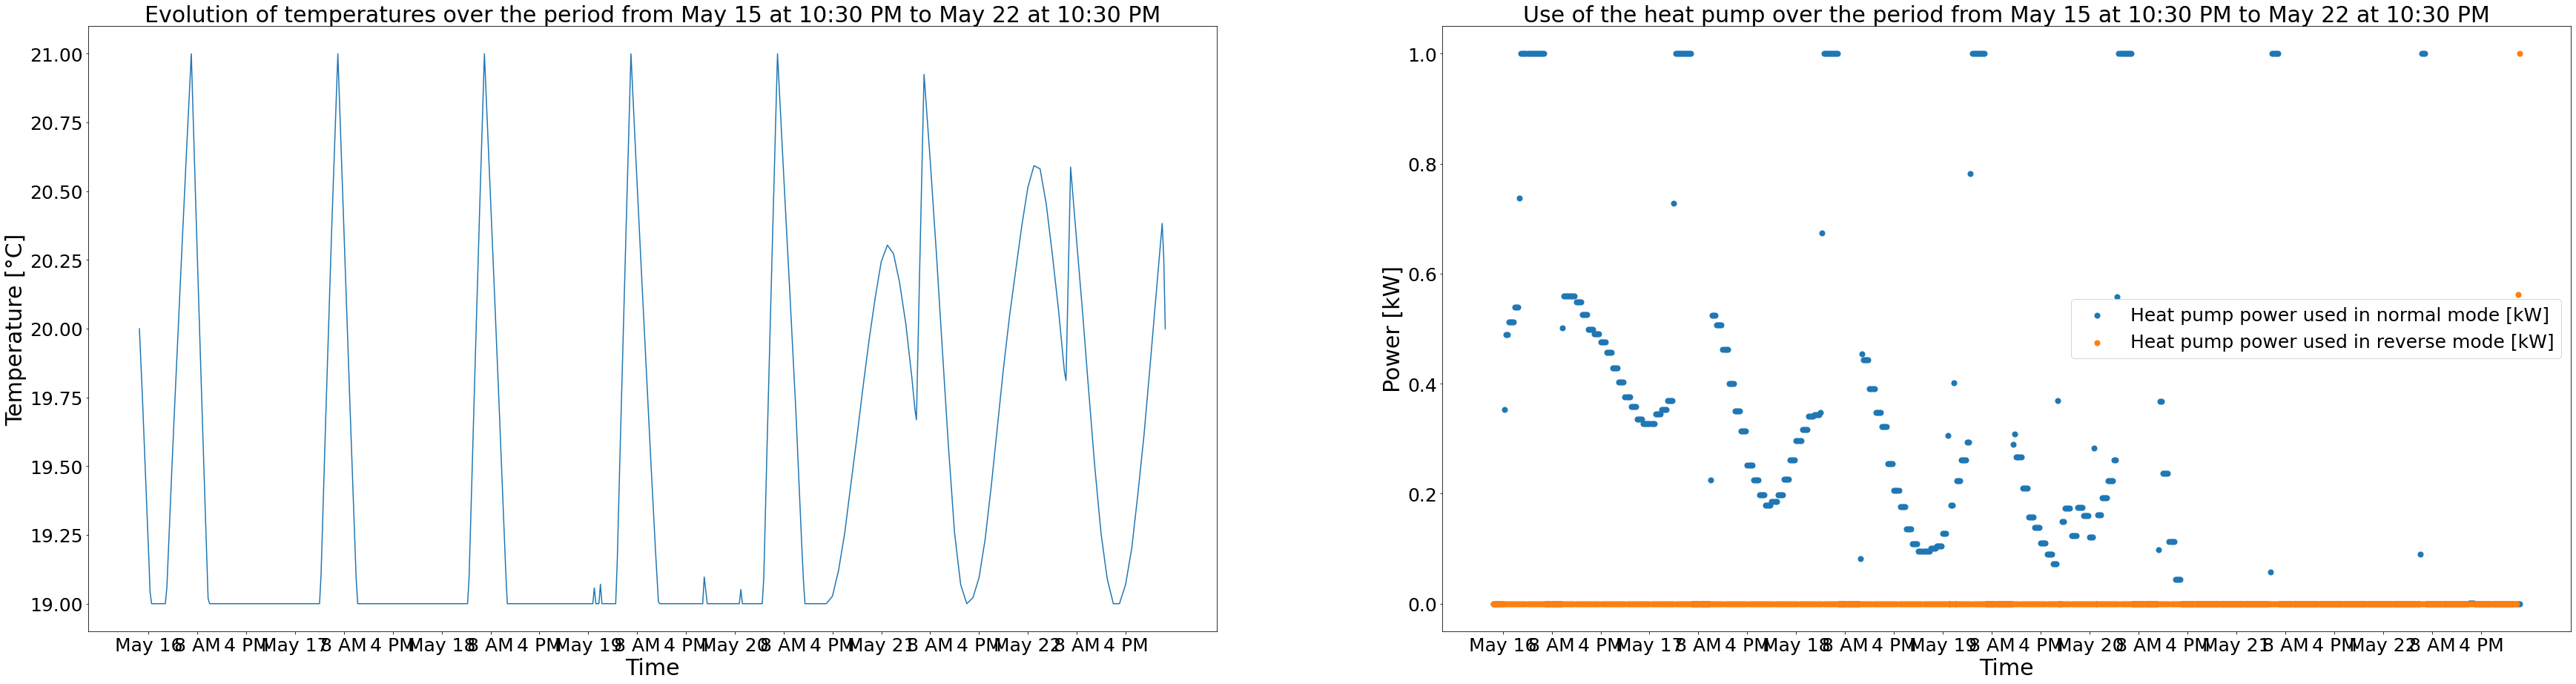

In [6]:
if result1 == "infeasible":
    print(f"The problem is infeasible. The execution took {(t1-t0)*1000:.3f} ms.")
elif result1 == "unbounded":
    print(f"The problem is unbounded. The execution took {(t1-t0)*1000:.3f} ms.")
else:
    print(f"Minimum cost for the use of the heat pump during the period from May 16 at 10:30 PM to May 23 at 10:30 PM: {Cost1:.3f}$. The execution took {((t1-t0)*1000):.3f} ms.")
    graph(start, length, T1, x1, y1, ["May 15 at 10:30 PM", "May 22 at 10:30 PM"], np.arange(13050+6, 13050+672, 32),
          ["May 16", "8 AM", "4 PM", "May 17", "8 AM", "4 PM", "May 18", "8 AM", "4 PM", "May 19", "8 AM", "4 PM",
           "May 20", "8 AM", "4 PM", "May 21", "8 AM", "4 PM", "May 22", "8 AM", "4 PM"])

    

#### b) Time interval from June 26 at 2:00 to July 3 at 2:00


In [7]:
start = 17000
length = 7
t0 = time.time()
(result2, Cost2,T2,x2,y2) = min_cost(start, length)
t1 = time.time()

Minimal cost for the use of the heat pump during the period from June 26 at 2h to July 3 at 2h: 1.859$. Execution time: 68.501ms.


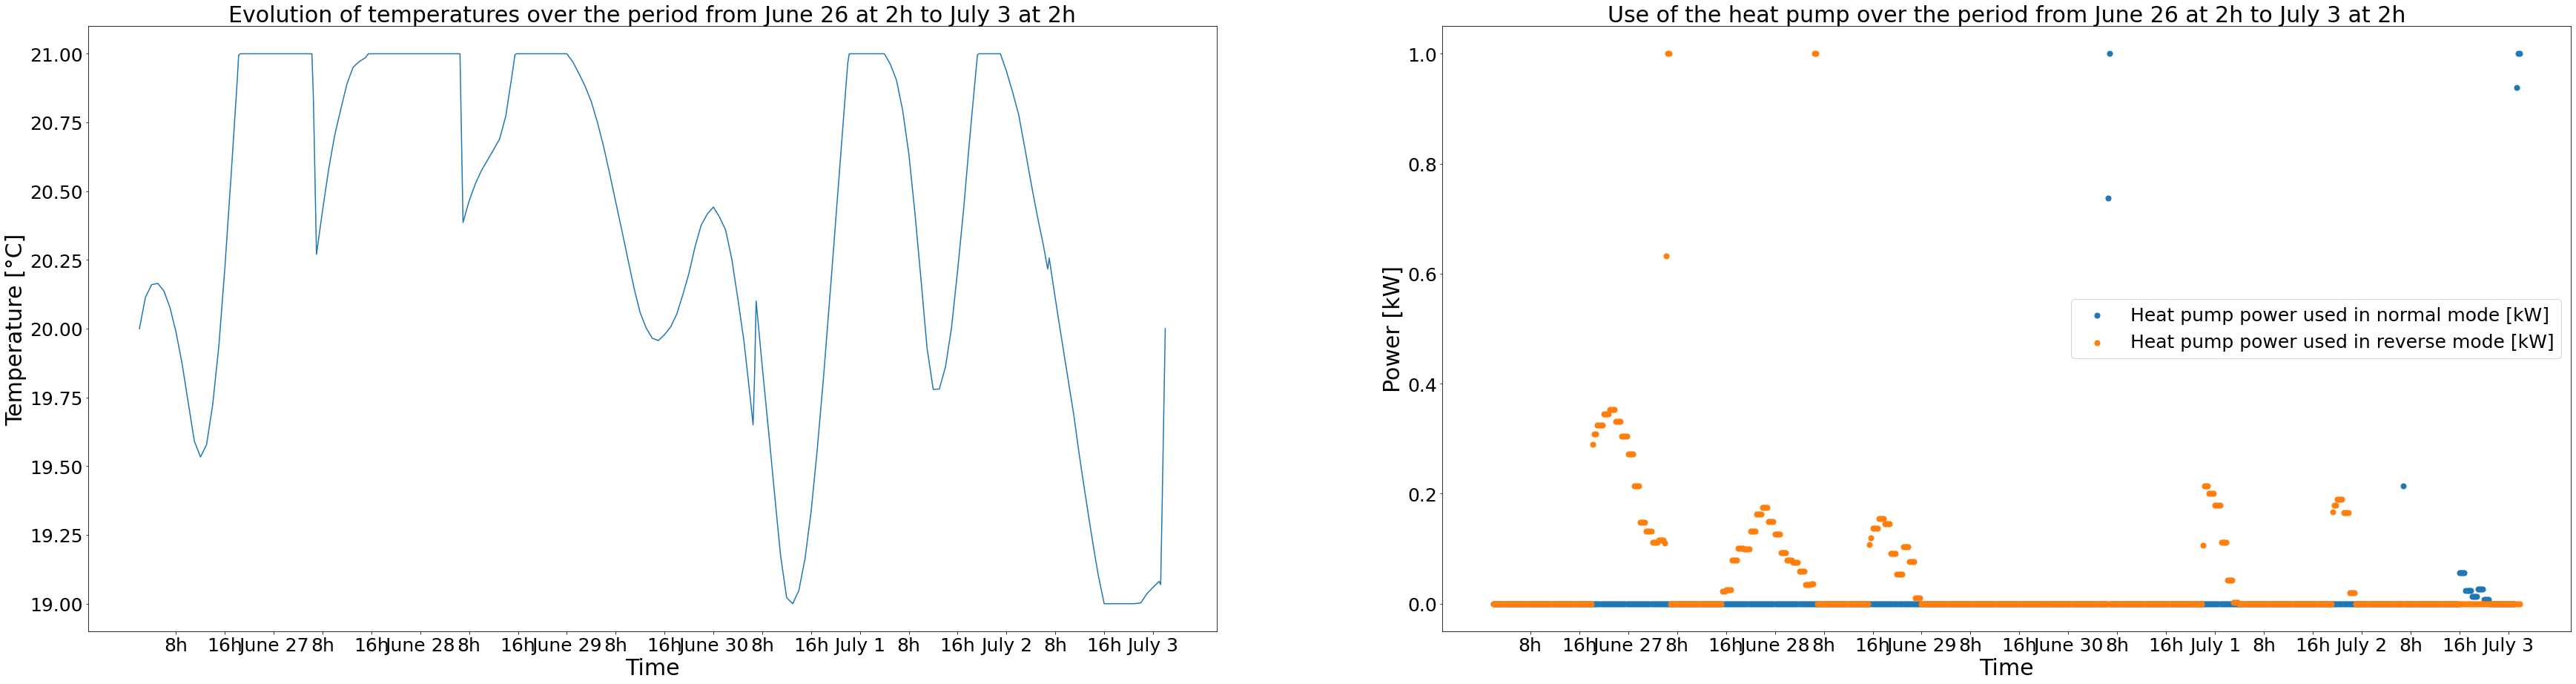

In [8]:
if result2 == "infeasible":
    print(f"Le problème est infaisable. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
elif result2 == "unbounded":
    print(f"Le problème est non borné. L'exécution a duré {(t1-t0)*1000:.3f}ms.")
else:
    print(f"Minimal cost for the use of the heat pump during the period from June 26 at 2h to July 3 at 2h: {Cost2:.3f}$. Execution time: {((t1-t0)*1000):.3f}ms.")
    graph(start, length, T2, x2, y2, ["June 26 at 2h", "July 3 at 2h"], np.arange(17000+24,17000+672,32),
          ["8h", "16h", "June 27", "8h", "16h", "June 28", "8h", "16h", "June 29", "8h", "16h", "June 30", "8h", "16h",
           "July 1", "8h", "16h", "July 2", "8h", "16h", "July 3"])


#### c) Comments

For both periods, the majority of tight constraints correspond to the non-use of the heat pump. Additionally, for cold (resp. hot) exterior temperatures, we observe more tight constraints on $T_{min}$ (resp. $T_{max}$). Furthermore, there is a correlation between peaks of heat pump usage in normal mode (resp. reverse) and temperature increases (resp. decreases). On the other hand, we notice that for both periods, the peaks of usage occur during the night when electricity is cheaper. Finally, when the exterior temperature is low (resp. high), the heat pump is more frequently used in normal mode (resp. reverse), and the indoor temperature tends to be in the lower (resp. upper) range of permissible temperatures.


<div class="alert alert-block alert-info"><b>Question 1.3</b> :<br> 
    Based on certain information provided by the solver (without performing new calculations), predict the effect on the optimal cost of a decrease in the minimum permissible temperature. Do the same for an increase in the maximum permissible temperature. Comment on this prediction, especially how valid it is for any variation in temperatures.
</div>


The objective function of the dual problem can be written as
$$\begin{align}
\max T_s.a + T_s.b + \sum_{j=0}^n (T_{min}.c_j + T_{max}.d_j) + \sum_{i=0}^{n-1}((1-\eta)T_{e,i}.e_i + \Omega.f_i)
\end{align}$$
with $a$, $b$, $c_j$, $d_j$, $e_i$, and $f_i$ being the variables, $j = 0,...,n$, and $i = 0,...,n-1$.

Furthermore, in the dual, $a$, $b$, and $e_i$ are free variables, $c_j \geq 0$, and $d_j$, $f_i \leq 0$.

By the strong duality theorem, which can be applied here as we are solving a linear optimization problem, if the primal has a finite optimal cost, then the dual also has a finite optimal cost, and these two costs are equal (and vice versa). Therefore, we observe that if $T_{min}$ decreases, the solution of the dual problem will decrease (since $c_j \geq 0$), and consequently, the primal solution will decrease as well. If $T_{max}$ increases, the solution of the dual problem will also decrease (since $d_j \leq 0$), and the primal solution will follow suit. We thus conclude that widening the range of permissible temperatures will reduce the minimal cost.

A modification $T_{min} \mapsto T_{min} - \Delta T_{min}$ will thus lead to a decrease in the optimal cost of approximately (as the basis varies slightly) $\Delta T_{min} \sum_{i = 0}^{n} c_{j}^{*}$, where $c_j^*$ are the optimal solutions of the dual variables related to the constraints $T_j \geq T_{min}$. With information provided by the solver, we find that the sum of $c_j^*$ is approximately $1.4085$ for the first period. A decrease in $\Delta T_{min}$ will locally lead to a decrease of $1.4085\Delta T_{min} \$$/$^{\circ}C$.

A modification $T_{max} \mapsto T_{max} + \Delta T_{max}$ will lead to a decrease in the optimal cost of approximately (as the basis varies slightly) $\Delta T_{max} \sum_{i = 0}^{n} d_{j}^{*}$, where $d_j^*$ are the optimal solutions of the dual variables related to the constraints $T_j \leq T_{max}$. With information provided by the solver, we find that the sum of $d_j^*$ is approximately $0.0976$ for the first period. An increase in $\Delta T_{max}$ will locally lead to a decrease of $0.0976\Delta T_{max} \$$/$^{\circ}C$.

Similarly, further restricting the range of permissible temperatures will increase the minimal cost.

This prediction is not valid for all temperature variations but only when the basis does not vary much (and thus for bounds close to the initial bounds). The approximation is local.


<div class="alert alert-block alert-info"><b>Question 1.4</b> :<br> 
   Demonstrate that, in an optimal solution, the simultaneous activation of heating and reverse mode during the same time period is impossible.
</div>


It is impossible for the heat pump to be used in both heating and reverse modes simultaneously in an optimal solution. Indeed, since both uses incur a positive cost, employing the heat pump to heat the room and simultaneously using it to cool the room is contradictory. It is more effective in this case to use it only in normal mode (or reverse) with a lower power to directly reach the desired temperature. This approach allows for using the heat pump in normal mode (or reverse) with lower power and avoiding its use in reverse mode (or normal), reducing costs on both fronts. The goal is to minimize cost, making this approach more favorable than using the heat pump in both modes simultaneously.


<div class="alert alert-block alert-info"><b>Question 1.5</b> :<br> 
    Modify your model to account for the following new constraints:<br>
    - If the heat pump is used (in any mode), it must operate at least at 25% of its maximum power. Using the heat pump at very low power is no longer allowed.
<br>
    - If the decision to turn on (or off) the heat pump is made, it remains on (or off) for a consecutive period of x hours. These periods are fixed: for example, if x=4h, it corresponds to [0h-4h], [4h-8h], [8h-12h], [12h-16h], etc., for each day.<br>
    The new model will still be necessarily linear but may involve discrete variables. 
    Provide your formulation and comment briefly.
</div>


(a) We have that either $x_i \ge \frac{\Omega}{4}$ or $x_i = 0$, and either $y_i \ge \frac{\Omega}{4}$ or $y_i = 0$. This can be rewritten as $-x_i \le -\frac{\Omega}{4}$ or $x_i \leq 0$, and $-y_i \le -\frac{\Omega}{4}$ or $y_i \le 0$ since $x_i$, $y_i \geq 0$.

Consider the constraint $-x_{i} \le -\frac{\Omega}{4}$ or $x_i \leq 0$. To express that exactly one of these two constraints is satisfied for each $i$, we introduce binary variables $a_i$ such that $-x_{i} + \frac{\Omega}{4} \le M_1(1-a_i)$, $x_i \leq M_1a_i$, and $a_i \in \{0,1\}$, with $M_1$ a sufficiently large constant such that $-x_{i} + \frac{\Omega}{4} \le M_1$ and $x_i \leq M_1$ hold for all $x_i$, $i = 0,...,n-1$, in the domain. Since $0 \leq x_i + y_i \leq \Omega$ and $x_i$, $y_i \geq 0$, we see that $M_1 = \Omega$ satisfies both conditions. Note that this method allows only to demand that at least one of the two constraints is satisfied, but since the two constraints cannot be satisfied simultaneously, we have that exactly one of the two constraints will be satisfied.

Similarly, we obtain for the constraint $-y_{i} \le -\frac{\Omega}{4}$ or $y_i \le 0$ that $-y_{i} + \frac{\Omega}{4} \le \Omega(1-b_i)$, $y_i \leq \Omega b_i$, and $b_i \in \{0,1\}$.

This can be interpreted as $a_i = 1$ if the heat pump is on in normal mode (in this case, $x_i \ge \frac{\Omega}{4}$) and $0$ otherwise (in this case, $x_i \leq 0$ and hence $x_i = 0$), and $b_i = 1$ if the heat pump is on in reverse mode (in this case, $y_i \ge \frac{\Omega}{4}$) and $0$ otherwise (in this case, $y_i \leq 0$ and hence $y_i = 0$).

In conclusion, we add to the model the constraints
$$\begin{align}
-x_{i} + \frac{\Omega}{4} &\le \Omega(1-a_i), i = 0,...,n-1\\
x_i &\leq \Omega a_i, i = 0,...,n-1\\
-y_{i} + \frac{\Omega}{4} &\le \Omega(1-b_i), i = 0,...,n-1\\
y_i &\leq \Omega b_i, i = 0,...,n-1\\
a_i, b_i &\in \{0,1\}, i = 0, ..., n-1
\end{align}$$

(b) Note: We consider semi-open intervals to the right. This means that the heat pump is on or off on $[0h, 4h[, [4h, 8h[ ...$. Furthermore, if the optimization period starts, for example, at 22h30, these intervals are shifted to $[22h30, 2h30[, [2h30, 6h30[ ...$.

These variables $a_i$ and $b_i$ will also allow us to address the second part of the question. Let $X$ be the number of consecutive hours the pump must remain on. We have
$$\begin{align}
&\sum_{i = 0}^{\frac{60X}{m}-1} a_{i+k.\frac{60X}{m}} \geq \frac{60X}{m} \oplus \sum_{i = 0}^{\frac{60X}{m}-1}a_{i+k.\frac{60X}{m}} = 0\\
&\sum_{i = 0}^{\frac{60X}{m}-1} b_{i+k.\frac{60X}{m}} \geq \frac{60X}{m} \oplus \sum_{i = 0}^{\frac{60X}{m}-1}b_{i+k.\frac{60X}{m}} = 0,
\end{align}$$
which is equivalent to
$$\begin{align}
&-\sum_{i = 0}^{\frac{60X}{m}-1} a_{i+k.\frac{60X}{m}} \leq -\frac{60X}{m} \oplus \sum_{i = 0}^{\frac{60X}{m}-1}a_{i+k.\frac{60X}{m}} \leq 0\\
&-\sum_{i = 0}^{\frac{60X}{m}-1} b_{i+k.\frac{60X}{m}} \leq -\frac{60X}{m} \oplus \sum_{i = 0}^{\frac{60X}{m}-1}b_{i+k.\frac{60X}{m}} \leq 0
\end{align}$$
since the $a_{i+kmX}$ and $b_{i+kmX}$ are positive, with $k = 0,..., \frac{nm}{60X}-1$, each k denoting an interval of X hours.
Note: $\frac{60X}{m}$ represents the number of $m$-minute intervals in $X$ hours.

These constraints can be reformulated using the alternative constraints
$$\begin{align}
\frac{60X}{m} - \sum_{i = 0}^{\frac{60X}{m}-1} a_{i+k.\frac{60X}{m}} &\le M'_1(1-c_k)\\
\sum_{i = 0}^{\frac{60X}{m}-1}a_{i+k.\frac{60X}{m}} &\le M'_1c_k\\
\frac{60X}{m} - \sum_{i = 0}^{\frac{60X}{m}-1} b_{i+k.\frac{60X}{m}} &\le M'_2(1-d_k)\\
\sum_{i = 0}^{\frac{60X}{m}-1}b_{i+k.\frac{60X}{m}} &\le M'_2d_k\\
c_k, d_k &\in \{0,1\}\\
\end{align}$$

This can be interpreted as $c_i = 1$ if the heat pump is on in normal mode for $X$h and $0$ otherwise, and $d_i = 1$ if the heat pump is on in reverse mode for $X$h and $0$ otherwise.

We still need to find the values of $M'_1$ and $M'_2$. Since $0 \leq a_{i+k.\frac{60X}{m}}, b_{i+k.\frac{60X}{m}} \leq 1$, we see that $M'_1 = M'_2 = \frac{60X}{m}$ is suitable.

In conclusion, we add to the model the constraints
$$\begin{align}
\frac{60X}{m} - \sum_{i = 0}^{\frac{60X}{m}-1} a_{i+k.\frac{60X}{m}} &\le \frac{60X}{m}(1-c_k), k = 0,..., \frac{nm}{60X}-1\\
\sum_{i = 0}^{\frac{60X}{m}-1}a_{i+k.\frac{60X}{m}} &\le \frac{60X}{m}c_k, k = 0,..., \frac{nm}{60X}-1\\
\frac{60X}{m} - \sum_{i = 0}^{\frac{60X}{m}-1} b_{i+k.\frac{60X}{m}} &\le \frac{60X}{m}(1-d_k), k = 0,..., \frac{nm}{60X}-1\\
\sum_{i = 0}^{\frac{60X}{m}-1}b_{i+k.\frac{60X}{m}} &\le \frac{60X}{m}d_k, k = 0,..., \frac{nm}{60X}-1\\
c_k, d_k &\in \{0,1\}, k = 0,..., \frac{nm}{60X}-1\\
\end{align}$$


<div class="alert alert-block alert-info"><b>Question 1.6</b>:
    Solve this new model, display the results, and comment (especially on the computation time). First, choose a value x=4h, then x=2h.
</div>


In [9]:
def min_new_cost(start, length, X):
    """
    This function calculates the moments at which we need to turn on a heat pump in a 360m³ building in Montreal to
    keep the indoor temperature within a certain acceptable range, while minimizing the cost of electricity.
    We consider a period of `length` days, starting at the moment `start`.

    Arguments
    ---------
    start  : int indicating the number of the moment starting the `length` days period [-];
    length : int indicating the number of days over which the optimization algorithm should be applied [day];
    X      : int indicating the duration of the intervals during which the heat pump should be turned on or off [h];

    Returns
    --------
    prob.status : string among {optimal, infeasible, unbounded} indicating if the problem solution is optimal,
                  if the problem is infeasible, or if the solution is unbounded;
    prob.value  : float indicating the minimum cost due to the use of the heat pump to stay within the acceptable
                  temperature range [$]. If the problem is impossible, prob.value = -inf. If the problem is unbounded,
                  prob.value = -inf;
    T.value     : numpy array of float indicating the temperature in the building during the `length` days period considered,
                  at intervals of m minutes [°C];
    x.value     : numpy array of float indicating the power of the heat pump, used in normal mode, during different
                  m minutes time intervals [kW];
    y.value     : numpy array of float indicating the power of the heat pump, used in reverse mode, during different
                  m minutes time intervals [kW];
    """
    
    # First, find the costs at different moments based on the location of the starting moment.
    cost = np.repeat(peak, intervals)
    beginning = start % intervals
    moments = np.concatenate((np.arange(beginning, intervals), np.arange(0, beginning)))
    cost[moments < start_peak*60/m] = off_peak
    cost[moments >= end_peak*60/m] = off_peak
    cost = np.tile(cost, length)

    # Next, find the outdoor temperatures at these moments and the COP of the heat pump used in the corresponding normal mode.
    outdoor_temp = outdoor_temperature[start : start+length*intervals]
    COP_normal = COPnormal(outdoor_temp)
    
    # Initialization of the problem variables
    T = cp.Variable(intervals*length + 1)
    x = cp.Variable(intervals*length, nonneg=True)
    y = cp.Variable(intervals*length, nonneg=True)
    a = cp.Variable(intervals*length, boolean=True)
    b = cp.Variable(intervals*length, boolean=True)
    c = cp.Variable(int(intervals*length*m/(60*X)), boolean=True)
    d = cp.Variable(int(intervals*length*m/(60*X)), boolean=True)
    
    # Problem modeling
    objective = cp.Minimize(cp.sum(cp.multiply(cost, (x + y)))*m/60)
    constraints = [T[0] == Tinit,
                   T[-1] == Tinit,
                   T >= Tinf,
                   T <= Tsup,
                   T[1:] == eta*T[:672] + (1-eta)*outdoor_temp + cp.multiply(COP_normal, x)/(10*capCal) - (COPreverse*y)/(10*capCal),
                   x + y <= max_power,
                   -x + max_power/4 <= max_power*(1-a), x <= max_power*a,
                   -y + max_power/4 <= max_power*(1-b), y <= max_power*b
                  ]
    for k in range(int(intervals*length*m/(60*X))):
        constraints.append(60*X/m - cp.sum(a[int(k*60*X/m):int((k+1)*60*X/m)]) <= 60*X*(1-c[k])/m)
        constraints.append(cp.sum(a[int(k*60*X/m):int((k+1)*60*X/m)]) <= 60*X*c[k]/m)
        constraints.append(60*X/m - cp.sum(b[int(k*60*X/m):int((k+1)*60*X/m)]) <= 60*X*(1-d[k])/m)
        constraints.append(cp.sum(b[int(k*60*X/m):int((k+1)*60*X/m)]) <= 60*X*d[k]/m)

    # Problem solving
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"})
    
    return (prob.status, prob.value, T.value, x.value, y.value)


#### a) Time interval from May 15 at 10:30 PM to May 22 at 10:30 PM

In [10]:
start = 13050
length = 7
t0 = time.time()
(result1, Cost1,T1,x1,y1) = min_new_cost(start, length, 4) # Mandatory 4-hour intervals
t1 = time.time()

Minimum cost for the use of the heat pump during the period from May 15 at 22:30 to May 23 at 22:30: 8.904$. Execution took 3633.181ms.


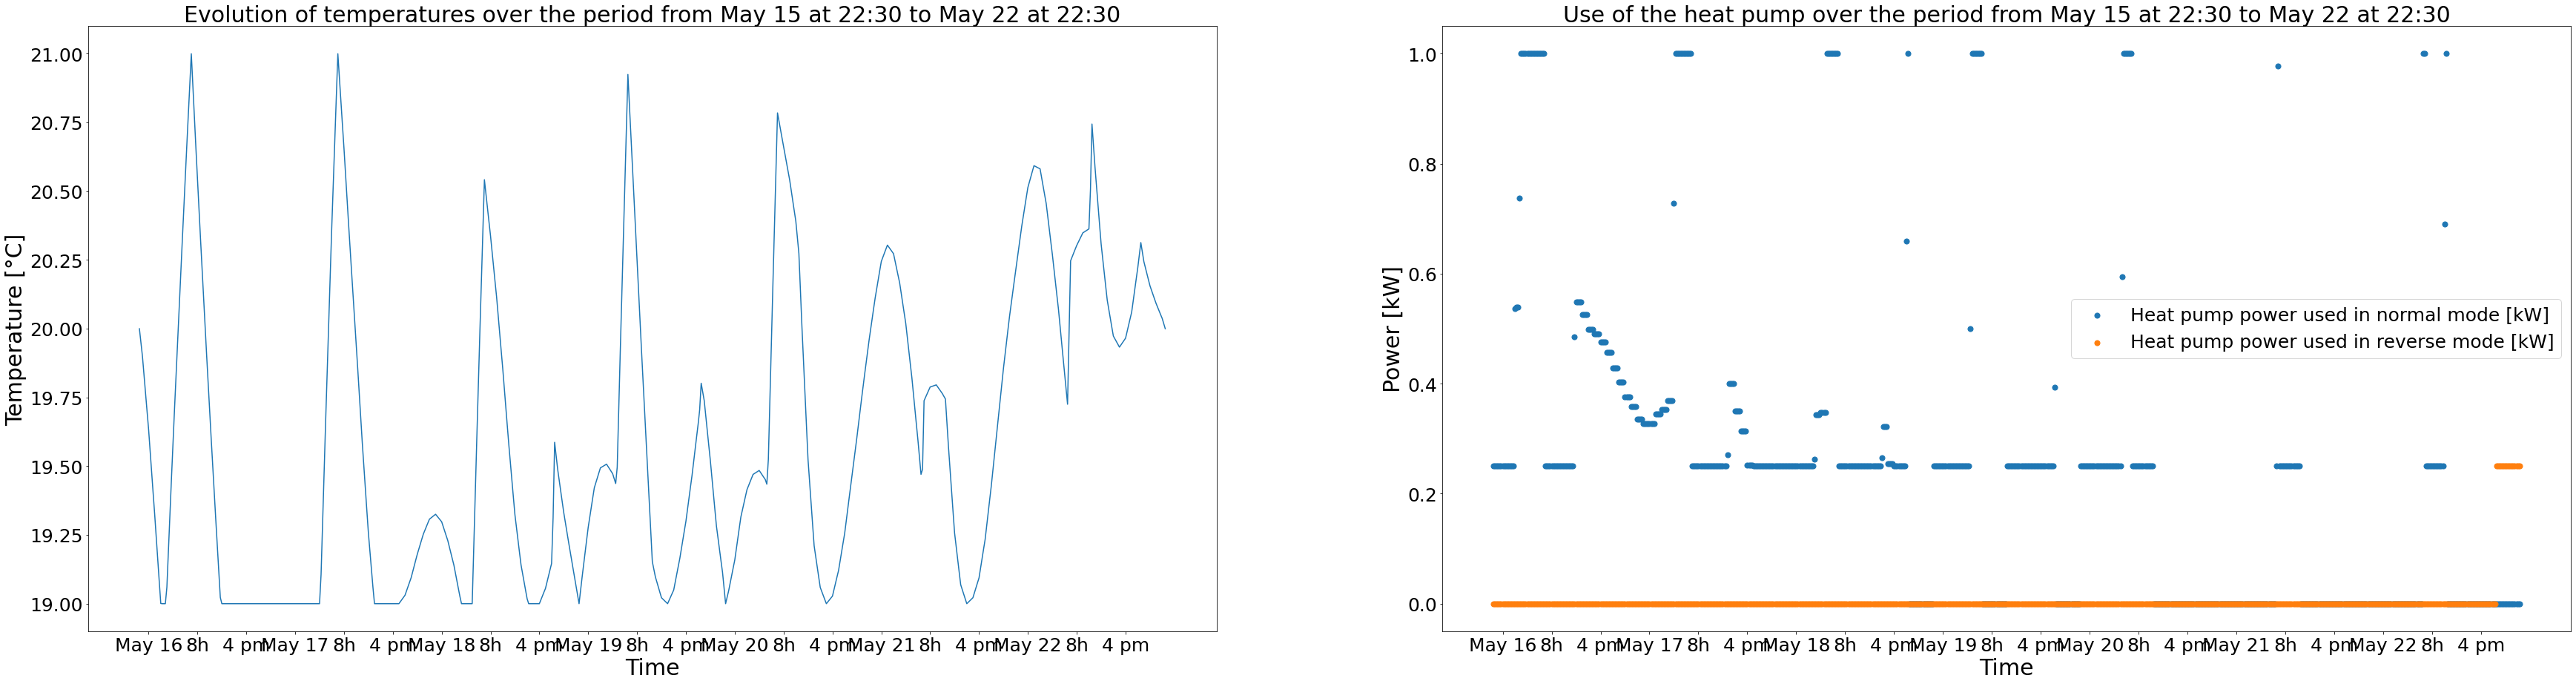

In [11]:
if result1 == "infeasible":
    print(f"The problem is infeasible. Execution took {(t1 - t0) * 1000:.3f}ms.")
elif result1 == "unbounded":
    print(f"The problem is unbounded. Execution took {(t1 - t0) * 1000:.3f}ms.")
else:
    print(f"Minimum cost for the use of the heat pump during the period from May 15 at 22:30 to May 23 at 22:30: {Cost1:.3f}$. Execution took {((t1 - t0) * 1000):.3f}ms.")
    graph(start, length, T1, x1, y1, ["May 15 at 22:30", "May 22 at 22:30"], np.arange(13050 + 6, 13050 + 672, 32), ["May 16", "8h", "4 pm", "May 17", "8h", "4 pm", "May 18", "8h", "4 pm", "May 19", "8h", "4 pm", "May 20", "8h", "4 pm", "May 21", "8h", "4 pm", "May 22", "8h", "4 pm"])


In [12]:
start = 13050
length = 7
t0 = time.time()
(result1, Cost1,T1,x1,y1) = min_new_cost(start, length, 2) # Mandatory 2-hour intervals
t1 = time.time()

Minimum cost for the use of the heat pump during the period from May 15 at 22:30 to May 23 at 22:30: 8.424$. Execution took 4885.908ms.


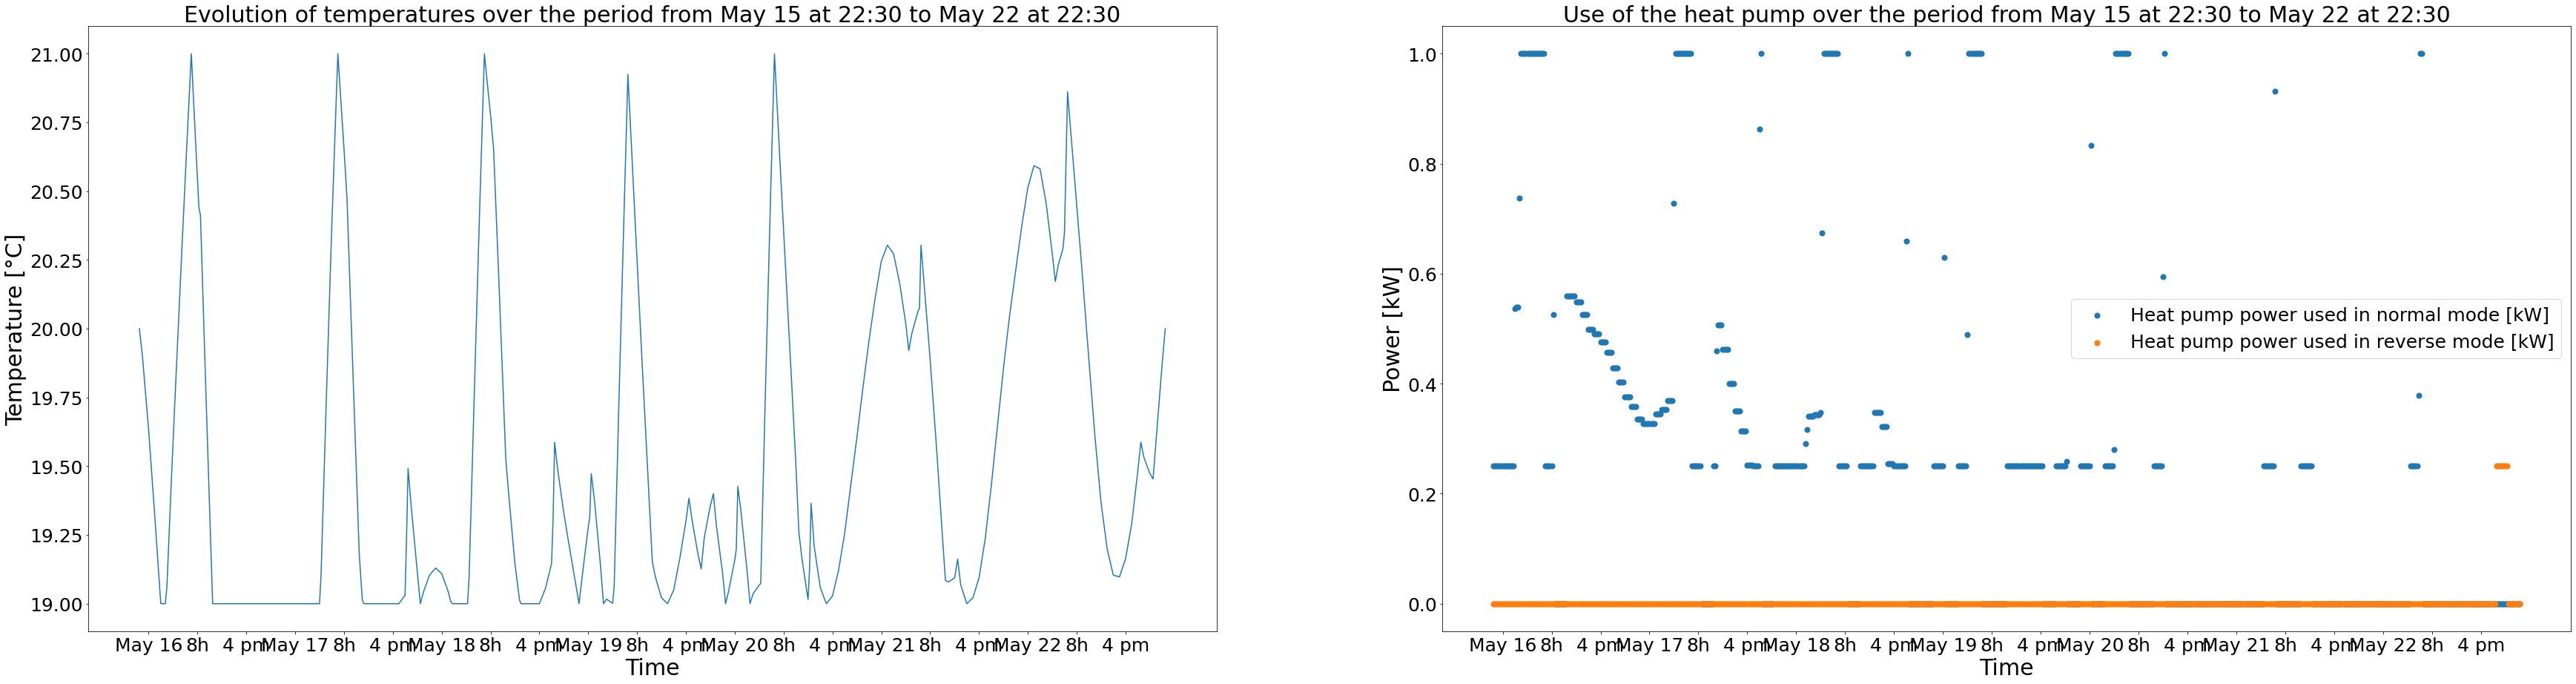

In [13]:
if result1 == "infeasible":
    print(f"The problem is infeasible. Execution took {(t1-t0)*1000:.3f}ms.")
elif result1 == "unbounded":
    print(f"The problem is unbounded. Execution took {(t1-t0)*1000:.3f}ms.")
else:
    print(f"Minimum cost for the use of the heat pump during the period from May 15 at 22:30 to May 23 at 22:30: {Cost1:.3f}$. Execution took {((t1-t0)*1000):.3f}ms.")
    graph(start, length, T1, x1, y1, ["May 15 at 22:30", "May 22 at 22:30"], np.arange(13050+6,13050+672,32),["May 16", "8h", "4 pm", "May 17", "8h", "4 pm", "May 18", "8h", "4 pm", "May 19", "8h", "4 pm", "May 20", "8h", "4 pm", "May 21", "8h", "4 pm", "May 22", "8h", "4 pm"])


#### b) Time interval from June 26 at 2:00 to July 3 at 2:00


In [14]:
start = 17000
length = 7
t0 = time.time()
(result2, Cout2,T2,x2,y2) = min_new_cost(start, length, 4) # Mandatory 4-hour intervals
t1 = time.time()

Minimum cost for the use of the heat pump during the period from June 26 at 2:00 to July 3 at 2:00: 2.626$. Execution took 7478.744ms.


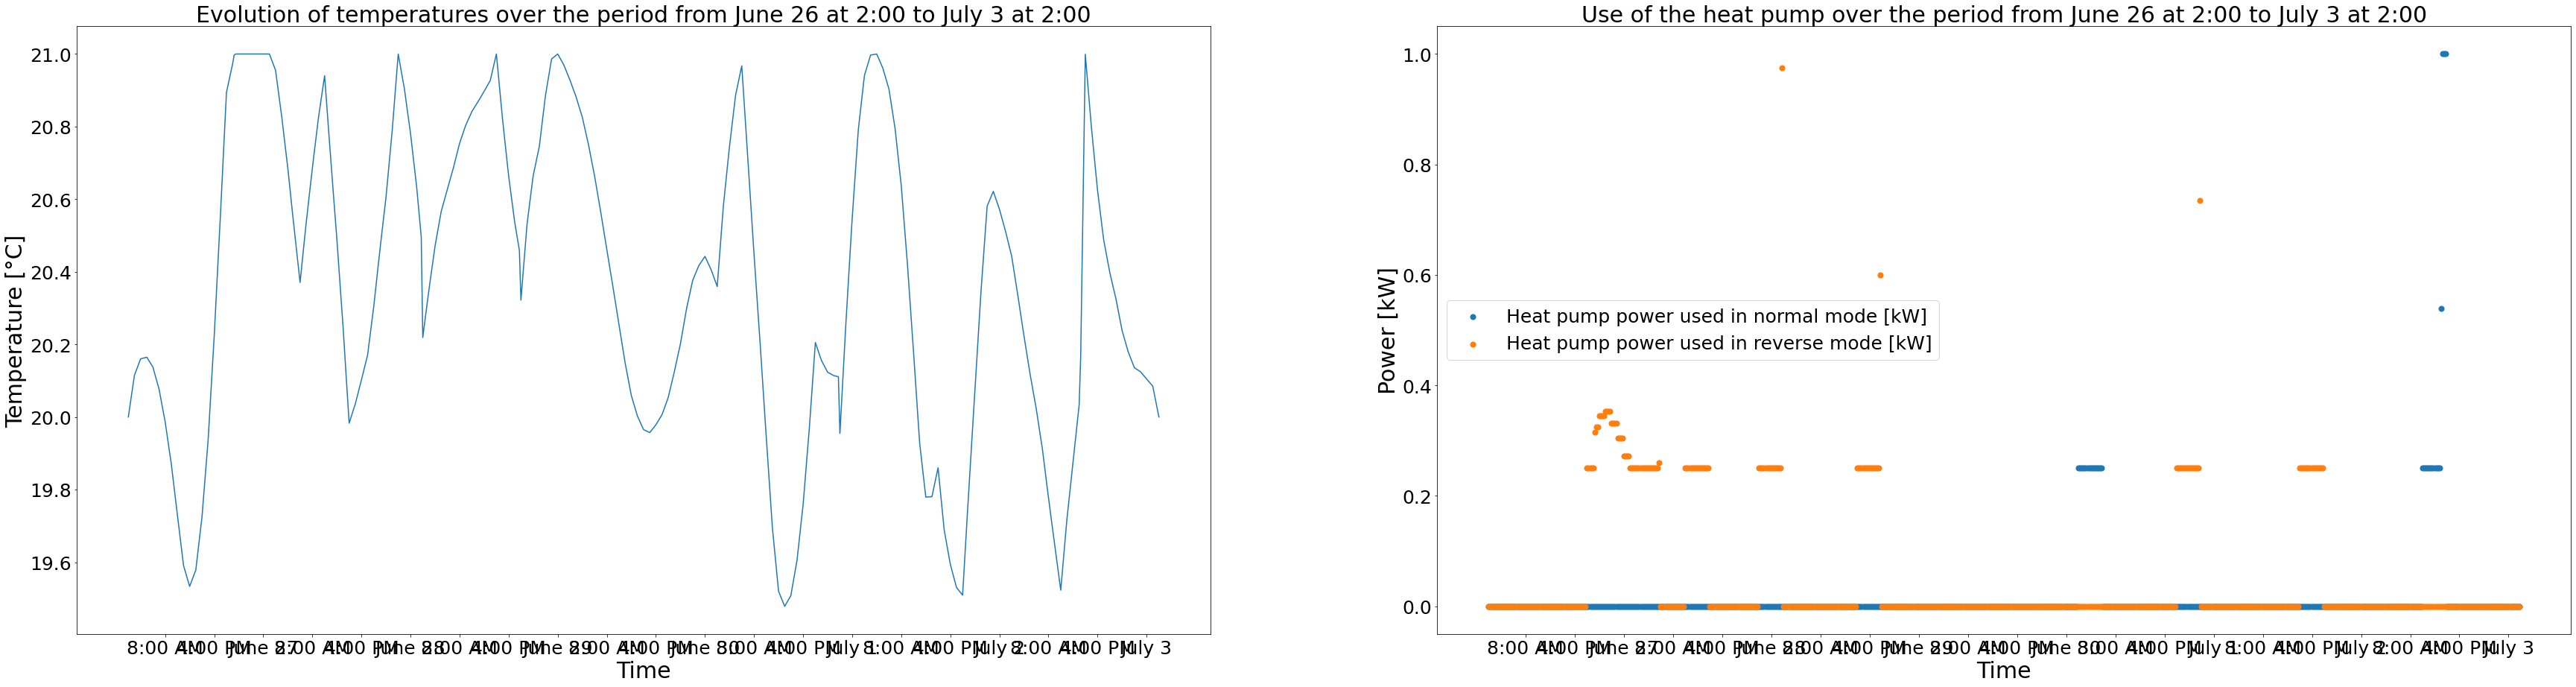

In [15]:
if result2 == "infeasible":
    print(f"The problem is infeasible. Execution took {(t1-t0)*1000:.3f}ms.")
elif result2 == "unbounded":
    print(f"The problem is unbounded. Execution took {(t1-t0)*1000:.3f}ms.")
else:
    print(f"Minimum cost for the use of the heat pump during the period from June 26 at 2:00 to July 3 at 2:00: {Cout2:.3f}$. Execution took {((t1-t0)*1000):.3f}ms.")
    graph(start, length, T2, x2, y2, ["June 26 at 2:00", "July 3 at 2:00"], np.arange(17000+24,17000+672,32),["8:00 AM", "4:00 PM", "June 27", "8:00 AM", "4:00 PM", "June 28", "8:00 AM", "4:00 PM", "June 29", "8:00 AM", "4:00 PM", "June 30", "8:00 AM", "4:00 PM", "July 1", "8:00 AM", "4:00 PM", "July 2", "8:00 AM", "4:00 PM", "July 3"])


In [16]:
start = 17000
length = 7
t0 = time.time()
(result2, Cout2,T2,x2,y2) = min_new_cost(start, length, 2) # Mandatory 2-hour intervals
t1 = time.time()

Minimum cost for the use of the heat pump during the period from June 26 at 2:00 to July 3 at 2:00: 1.969$. Execution took 3261.610ms.


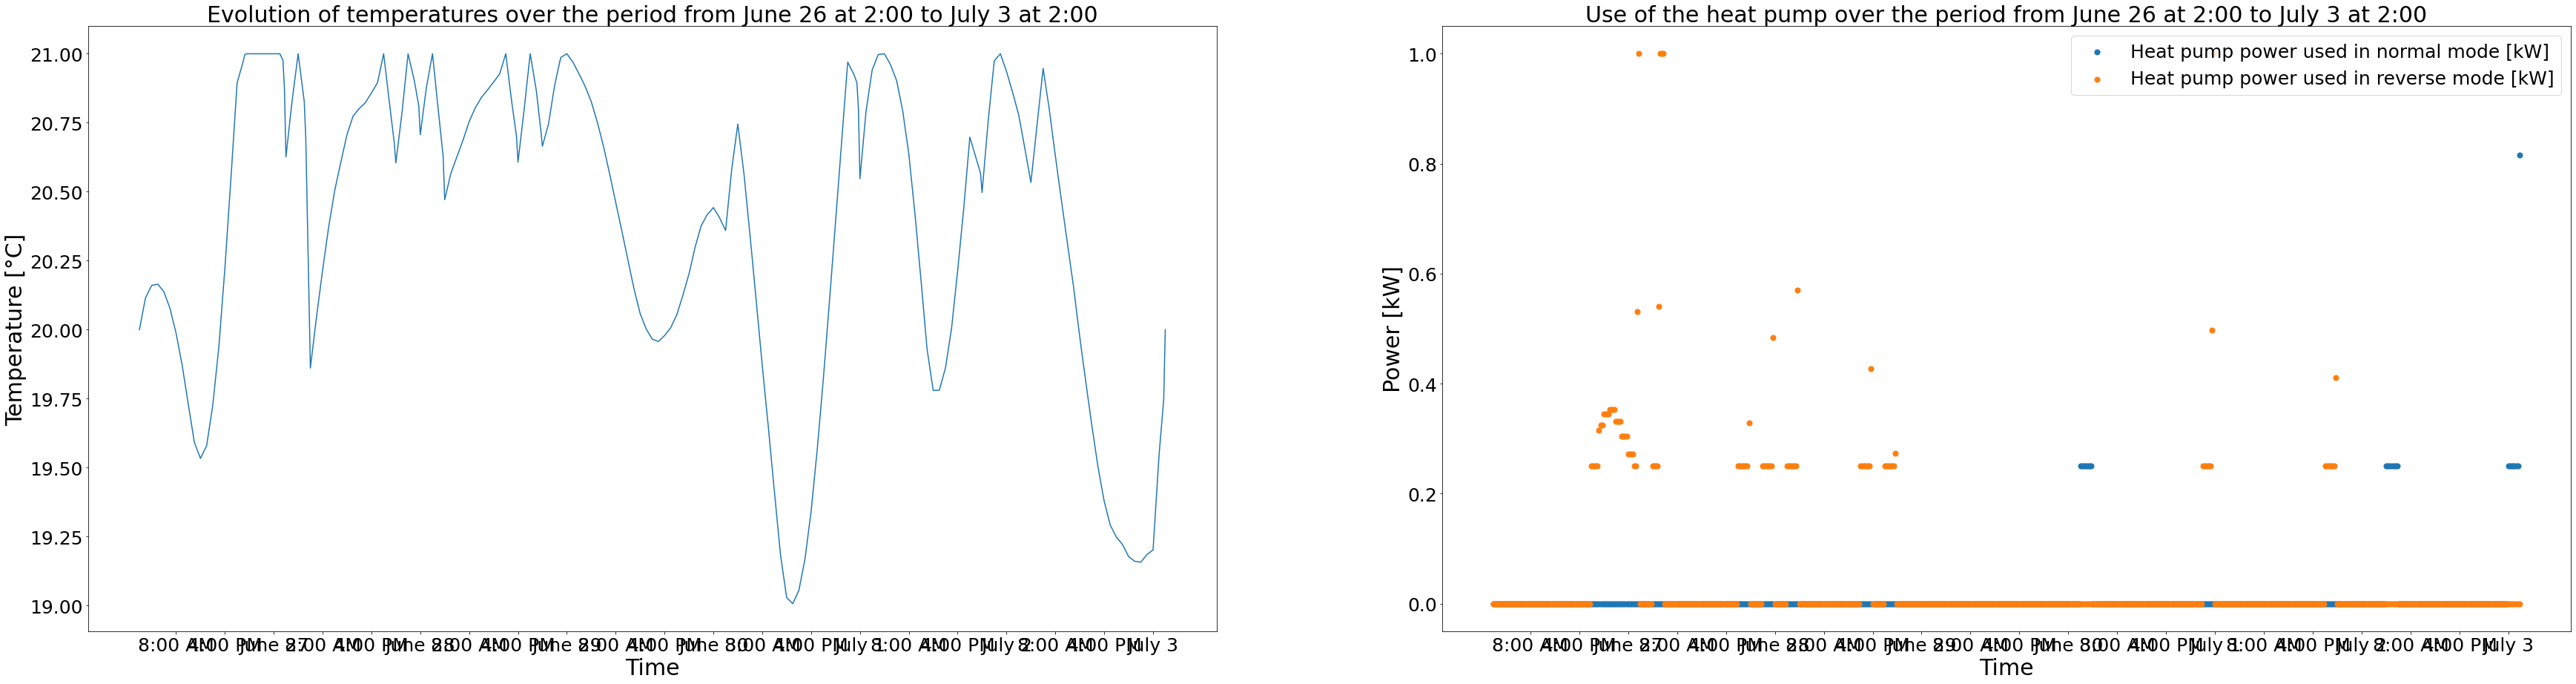

In [17]:
if result2 == "infeasible":
    print(f"The problem is infeasible. Execution took {(t1-t0)*1000:.3f}ms.")
elif result2 == "unbounded":
    print(f"The problem is unbounded. Execution took {(t1-t0)*1000:.3f}ms.")
else:
    print(f"Minimum cost for the use of the heat pump during the period from June 26 at 2:00 to July 3 at 2:00: {Cout2:.3f}$. Execution took {((t1-t0)*1000):.3f}ms.")
    graph(start, length, T2, x2, y2, ["June 26 at 2:00", "July 3 at 2:00"], np.arange(17000+24,17000+672,32),["8:00 AM", "4:00 PM", "June 27", "8:00 AM", "4:00 PM", "June 28", "8:00 AM", "4:00 PM", "June 29", "8:00 AM", "4:00 PM", "June 30", "8:00 AM", "4:00 PM", "July 1", "8:00 AM", "4:00 PM", "July 2", "8:00 AM", "4:00 PM", "July 3"])


In [18]:
start = 17000
length = 7
t0 = time.time()
# Mandatory 8-hour intervals to observe that the heat pump can be used in both modes simultaneously.
(result2, Cost2, T2, x2, y2) = min_new_cost(start, length, 8)
t1 = time.time()


Minimum cost for the use of the heat pump during the period from June 26 at 2:00 to July 3 at 2:00: 5.113$. Execution took 4329.112ms.


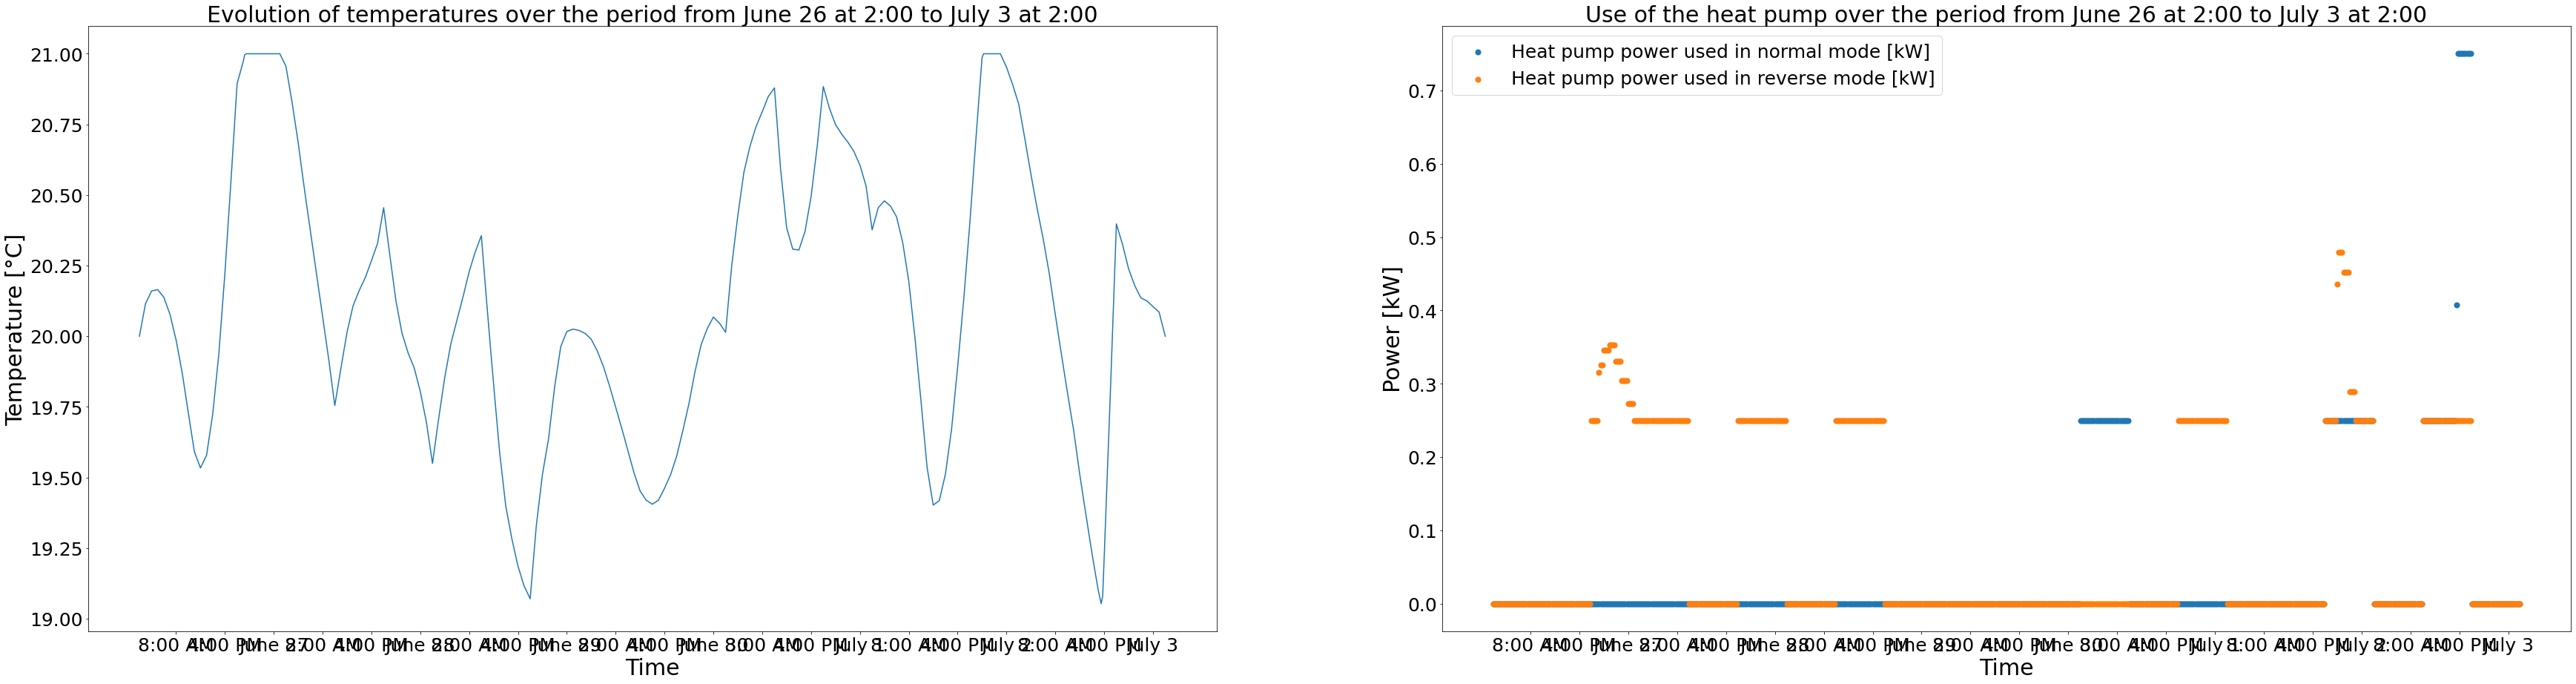

In [19]:
if result2 == "infeasible":
    print(f"The problem is infeasible. Execution took {(t1-t0)*1000:.3f}ms.")
elif result2 == "unbounded":
    print(f"The problem is unbounded. Execution took {(t1-t0)*1000:.3f}ms.")
else:
    print(f"Minimum cost for the use of the heat pump during the period from June 26 at 2:00 to July 3 at 2:00: {Cost2:.3f}$. Execution took {((t1-t0)*1000):.3f}ms.")
    graph(start, length, T2, x2, y2, ["June 26 at 2:00", "July 3 at 2:00"], np.arange(17000+24,17000+672,32),["8:00 AM", "4:00 PM", "June 27", "8:00 AM", "4:00 PM", "June 28", "8:00 AM", "4:00 PM", "June 29", "8:00 AM", "4:00 PM", "June 30", "8:00 AM", "4:00 PM", "July 1", "8:00 AM", "4:00 PM", "July 2", "8:00 AM", "4:00 PM", "July 3"])

#### c) Comments

We observe that the execution time for this new problem is much higher. This is due to the increase in the number of constraints. For the first period, the execution time is longer when $X = 2h$ than when $X = 4h$, whereas it is the opposite for the second period. This depends on the number of iterations of the resolution algorithm and the chance of quickly finding the optimal vertex or not.

Furthermore, we notice that the longer the periods during which the pump must be turned on or off, the higher the minimum cost and the more non-zero usage periods there are. However, the general shape of the temperature graphs remains the same.

Finally, as explained in question 1.7, we observe that it is possible to have the heat pump used in both modes simultaneously.

<div class="alert alert-block alert-info"><b>Question 1.7</b> :<br> 
    Describe how the following modifications could be made to the model (but without implementing them): <br>
    -(a) Take into account a fixed cost to pay for each time interval when the heat pump is used.<br>
    -(b) Minimize the number of activations of the heat pump (an activation = transition from the 'off' state during one time interval to the 'on' state during the next time interval).<br>
    -(c) In this new model, it is not necessarily impossible to observe simultaneous activation of the heating and reverse modes during the same time interval in an optimal solution: explain why and propose a constraint to eliminate this possibility.
</div>


(a) Taking the variables $c_i$ and $d_i$ defined in question 1.5, we need to add to the sum of the objective function the term $f\max \{c_i, d_i\}$, with $f$ being the fixed cost. Indeed, the fixed cost will be paid once if the pump is turned on in at least one of the two modes and will not be paid if both modes are off. Let $t_k$ be the variables such that $t_k \geq c_k$ and $t_k \geq d_k$, $k = 0,..., \frac{nm}{60X}-1$.

The new objective function becomes
$$\begin{align}
\text{min } &\sum_{i=0}^{n-1} \frac{c_i.m}{60}.(x_i+y_i) + \sum_{k=0}^{\frac{nm}{60X}-1}f.t_k
\end{align}$$
and we need to add the constraints $t_k \geq c_k$ and $t_k \geq d_k$, $k = 0,..., \frac{nm}{60X}-1$.

(b) An activation is represented by:
$$\begin{align}
t_{k-1} = 0\\
t_{k} = 1\\
\end{align}$$
with the initial condition that $t_{-1} = 0$.

We can model a binary variable $\lambda_{k}$ that is 1 during an activation and 0 otherwise through the following constraints:
$$\begin{align}
\lambda_{k} \in \{0,1\}\\
\lambda_{k} + t_{k-1} \le 1\\
t_{k} - t_{k-1} \le \lambda_{k} \le t_{k}
\end{align}$$
We can then formulate the objective function as
$$\begin{align}
\text{min } \sum_{k = 0}^{\frac{nm}{60X}-1} \lambda_{k}
\end{align}$$

(c) Since the pump must be turned on at $25\%$ of its power during a multi-hour interval, it is sometimes absolutely necessary to use it in one mode to stay in the permissible zone. However, using it for several hours can lead to exceeding the other temperature limit. Therefore, both modes must be used in different proportions to stay within the permissible zone during the interval.

To avoid this incident, we can impose the constraint that $x_i = 0 \lor y_i = 0$, $i = 0,...,n-1$, which can be rewritten as $x_i \leq 0 \lor y_i \leq 0$ because $x_i, y_i \geq 0$. Let $\psi_i$ be the binary variables, $i = 0,...,n-1$. This constraint can be modeled using alternative constraints:

$$\begin{align}
x_{i} &\le M(1-\psi_{i}), i = 0,...,n-1\\
y_{i} &\le M\psi_{i}, i = 0,...,n-1\\
\psi_i &\in \{0,1\}, i = 0,...,n-1
\end{align}$$

To find $M$, we observe that $M = \Omega$ is suitable, considering the constraint $x_i + y_i \leq \Omega$.

**Task 2:** We aim to reduce the cost of using the heat pump while setting the maximum budget to a certain proportion of the minimal cost identified in the first task. To decrease costs, we allow temperatures to go outside the defined permissible range (we also abandon the constraint on the final temperature, which becomes free). However, we will then account for the amount of _discomfort_ possibly experienced during each time interval, which will be proportional to the exceedance of the maximum permissible temperature or the fall below the minimum permissible temperature. We seek to **minimize the total discomfort** (the sum of discomforts over the entire considered period) **while respecting the budget constraint**. Formulate this problem as a linear optimization problem and then solve it.

<div class="alert alert-block alert-warning"><b>To mention</b>:<br> 
- Minimal discomfort + same graphs as for task 1 + computation time + brief comment (maximum 4 lines)<br>
- Again, for the two periods mentioned in task 1
</div>

<div class="alert alert-block alert-info"><b>Question 2.1</b> :<br> 
    Provide your linear formulation, with brief comments (especially if you use a modeling/reformulation technique).
</div>


Let the variables be:
- $T_j, j = 0,...,n$, the temperature in the building at time j [°C]. The $T_j$ are regularly spaced by $m$ minutes.
- $x_i, i = 0,...,n-1$, the power of the heat pump, used in normal mode, during the interval $[T_i, T_{i+1}]$ [kW].
- $y_i, i = 0,...,n-1$, the power of the heat pump, used in reverse mode, during the interval $[T_i, T_{i+1}]$ [kW].
- $\delta_j, j = 0,...,n$, the temperature difference with the lower bound of the permissible range if the temperature is below this lower bound [°C].
- $\epsilon_j, j = 0,...,n$, the temperature difference with the upper bound of the permissible range if the temperature is above this upper bound [°C].

The problem can be formulated as follows:

$$\begin{align}
\text{min} &\sum_{j=0}^{n} d_0.\delta_j + d_1.\epsilon_j \\
&T_0 = T_s\\
&\delta_j = 0 \vee \epsilon_j = 0, \text{  } j = 0,...,n\\
&\sum_{i=0}^{n-1} \frac{c_i.m}{60}.(x_i+y_i) \leq C\\
&\delta_j = T_{inf} - T_j \text{  if  } T_j < T_{inf}, 0 \text{ otherwise}, j = 0,...,n\\
&\epsilon_j = T_j - T_{sup} \text{  if  } T_j > T_{sup}, 0 \text{ otherwise}, j = 0,...,n\\
&T_{i+1} = \eta.T_i + (1-\eta).T_{e,i} + \frac{\alpha_i.x_i}{10.\gamma} - \frac{\beta.y_i}{10.\gamma}, i = 0,...,671\\
&x_i+y_i \leq \Omega, i = 0,...,n-1\\
&x_i, y_i, \delta_j, \epsilon_j \geq 0, \text{  } i = 0,...,n-1, j = 0,...,n\\
\end{align}$$

where:
- $d_0$, discomfort per degree Celsius below the minimum temperature per quarter-hour [-].
- $d_1$, discomfort per degree Celsius above the maximum temperature per quarter-hour [-].
- $T_s$, the temperature in the building at the beginning of the period [°C].
- $c_i, i = 0,...,n-1$, the cost of electricity during the interval $[T_i, T_{i+1}]$ (depends on whether it is off-peak or peak hours) [\$/kWh].
- $C$, the maximum cost willing to be paid for the use of the heat pump over the period of $m$ days [\$].
- $T_{inf}, T_{sup}$, the bounds on the permissible temperature [°C].
- $\eta$, a proportionality coefficient [-].
- $\alpha_i = 3 + 10.abs\left(tanh\left(\frac{T_{e,i}}{100}\right)\right).tanh\left(\frac{T_{e,i}}{100}\right)$, the coefficient of performance of the heat pump when used in normal mode during the interval $[T_i, T_{i+1}]$ [-].
- $\beta$, the coefficient of performance of the heat pump when used in reverse mode [-].
- $\gamma$, the number of $kWh$ needed to heat the room by $\theta^{\circ} C$ [kWh].
- $\Omega$, the maximum electrical power that the heat pump can consume [kW].

Remarks:
- If $c_i$ represents the price per kWh, then $\frac{c_i.m}{60}$ represents the price per kW for a usage of $m$ minutes.
- We need $\gamma \text{  } kW$ in an hour to heat (or cool) the building by $\theta^{\circ} C$. Therefore, we need $\frac{60}{m.\theta}.\gamma \text{  } kW$ in $m$ minutes to heat (or cool) the room by $1^{\circ} C$ in $m$ minutes. Thus, if $x_i$ (or $y_i$) represents the power of the heat pump used in normal (or reverse) mode during the interval $[T_i, T_{i+1}]$, the temperature in the room will increase (or decrease) by $\frac{m.\theta.\alpha_i.x_i}{60.\gamma}$ (or $\frac{m.\theta.\beta.y_i}{60.\gamma}$) during that interval.

There are three constraints that are not linear:
 - $\delta_j = 0 \vee \epsilon_j = 0, \text{  } j = 0,...,n$. However, we can "eliminate" this constraint by defining $\delta_j$ and $\epsilon_j$. Indeed, since these two variables are directly linked to $T_j$, it is not possible for both to be non-zero because $T_j$ has a unique value, and we cannot be simultaneously below the minimum temperature and above the maximum temperature;
 - $\delta_j = T_{inf} - T_j \text{  if  } T_j < T_{inf}, 0 \text{ otherwise}, j = 0,...,n$. This constraint can be represented as $\delta_j = \max(0,T_{inf} - T_j)$, which is equivalent to the two constraints $\delta_j \geq 0$ and $\delta_j \geq T_{inf} - T_j$. Since we want to minimize $\delta_j$, there will always be at least one of these two constraints that is tight because there is never an advantage to having a larger gap than the minimum possible;
 - $\epsilon_j = T_j - T_{sup} \text{  if  } T_j > T_{sup}, 0 \text{ otherwise}, j = 0,...,n$. This constraint can be represented as $\epsilon_j = \max(0,T_j - T_{sup})$, which is equivalent to the two constraints $\epsilon_j \geq 0$ and $\epsilon_j \geq T_j - T_{sup}$. Since we want to minimize $\epsilon_j$, there will always be at least one of these two constraints that is tight because there is never an advantage to having a larger gap than the minimum possible.

In the end, the problem boils down to
$$\begin{align}
\text{min} &\sum_{j=0}^{n} d_0.\delta_j + d_1.\epsilon_j \\
&T_0 = T_s\\
&\sum_{i=0}^{n-1} \frac{c_i}{4}.(x_i+y_i) \leq C\\
&\delta_j \geq T_{inf} - T_j, j = 0,...,n\\
&\epsilon_j \geq T_j - T_{sup}, j = 0,...,n\\
&T_{i+1} = \eta.T_i + (1-\eta).T_{e,i} + \frac{\alpha_i.x_i}{10.\gamma} - \frac{\beta.y_i}{10.\gamma}, i = 0,...,n-1\\
&x_i+y_i \leq \Omega, i = 0,...,n-1\\
&x_i, y_i, \delta_j, \epsilon_j \geq 0, \text{  } i = 0,...,n-1, j = 0,...,n\\
\end{align}$$

<div class="alert alert-block alert-info"><b>Question 2.2</b>:
    Solve your model for the two time intervals, display your results graphically, and provide comments. 
</div>

In [20]:
def min_discomfort(start, length, C):
    """
    This function calculates the times at which we should turn on a heat pump in a 360m³ building in Montreal
    to minimize the total discomfort, with a budget constraint.
    Discomfort at time j is defined as (less * max(0, T_inf - T_j) + greater * max(0, T_j - T_sup)).
    We consider a period of `length` days, starting at time `start`.

    Arguments
    ---------
    start         : int indicating the number of the time instant that starts the period of `length` days [-];
    length        : int indicating the number of days over which the optimization algorithm should be applied [days];
    C             : float indicating the maximum cost we are willing to pay for the use of the heat pump over a period of `length` days [$];

    Returns
    --------
    prob.status : string among {optimal, infeasible, unbounded} indicating if the problem solution is optimal,
                  if the problem is infeasible, or if the solution is unbounded;
    prob.value  : float indicating the minimal discomfort [-]. If the problem is infeasible, prob.value = -inf.
                  If the problem is unbounded, prob.value = -inf;
    T.value     : numpy array of float indicating the temperature in the building during the considered seven-day period,
                  in 15-minute intervals [°C];
    x.value     : numpy array of float indicating the power of the heat pump used in normal mode during different
                  15-minute time intervals [kW];
    y.value     : numpy array of float indicating the power of the heat pump used in reverse mode during different
                  15-minute time intervals [kW];
    """    
    # First, find the costs at different intervals based on the starting instant's location.
    c = np.repeat(peak, intervals)
    beginning = start % intervals
    moments = np.concatenate((np.arange(beginning, intervals), np.arange(0, beginning)))
    c[moments < start_peak * 60 / m] = off_peak
    c[moments >= end_peak * 60 / m] = off_peak
    c = np.tile(c, length)
    
    # Next, find the outdoor tempuperatures at these intervals and the COP of the heat pump used in normal mode.
    Te = outdoor_temperature[start : start + length * intervals]
    COPnor = COPnormal(Te)
    
    # Initialization of the problem variables
    T = cp.Variable(intervals * length + 1)
    x = cp.Variable(intervals * length, nonneg=True)
    y = cp.Variable(intervals * length, nonneg=True)
    ΔinfT = cp.Variable(intervals * length + 1, nonneg=True)
    ΔsupT = cp.Variable(intervals * length + 1, nonneg=True)
    
    # Problem modeling
    objective = cp.Minimize(cp.sum(less * ΔinfT + greater * ΔsupT))
    constraints = [T[0] == Tinit,
                   cp.sum(cp.multiply(c, (x + y)) * m / 60) <= C,
                   ΔinfT >= Tinf - T,
                   ΔsupT >= T - Tsup,
                   T[1:] == eta * T[:672] + (1 - eta) * Te + cp.multiply(COPnor, x) / (10 * capCal) - (COPreverse * y) / (10 * capCal),
                   x + y <= max_power]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start=True)
    
    # For question 3.2
    # print(constraints[1].dual_value)
    
    return (prob.status, prob.value, T.value, x.value, y.value)


#### a) Time interval from May 15th at 10:30 PM to May 22nd at 10:30 PM


In [21]:
start = 13050
length = 7
Cost1 = min_cost(start, length)[1]
t0 = time.time()
(result1, Discomfort1, T1, x1, y1) = min_discomfort(start, length, Cost1/2)
t1 = time.time()


Minimal discomfort during the period from May 15th at 22:30 to May 22nd at 22:30: 4492.241. Execution time: 99.864ms.


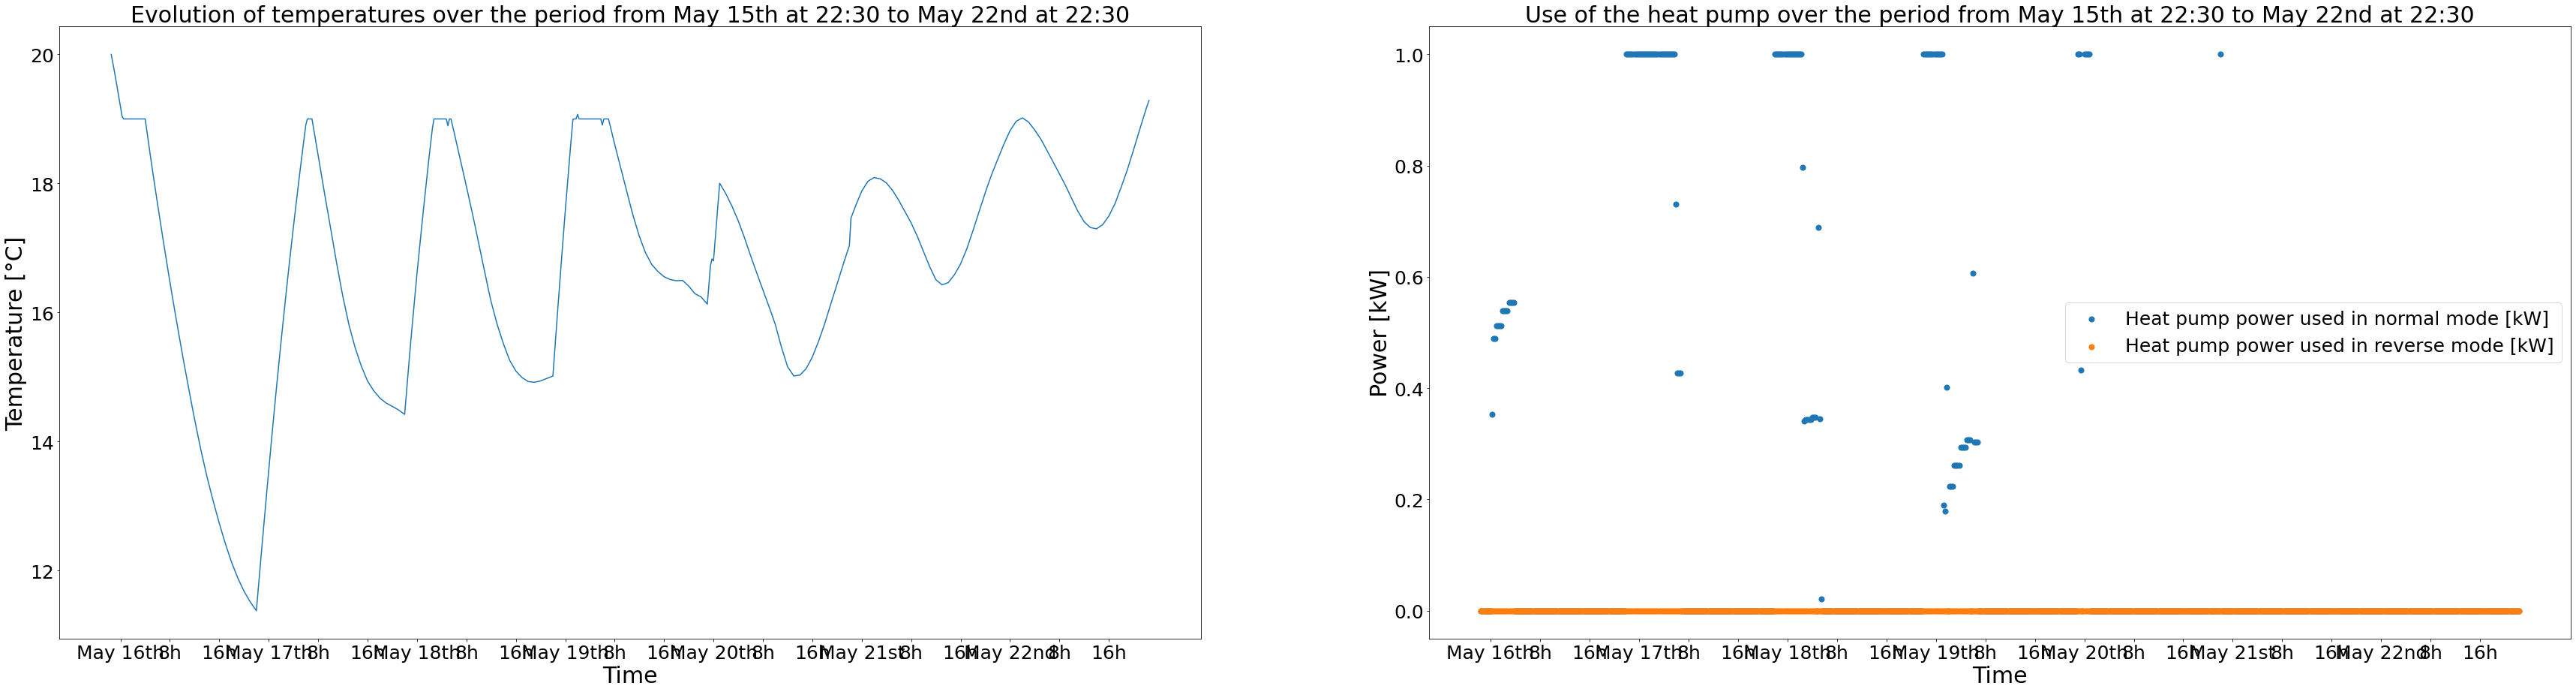

In [22]:
if result1 == "infeasible":
    print(f"The problem is infeasible. Execution time: {(t1 - t0) * 1000:.3f}ms.")
elif result1 == "unbounded":
    print(f"The problem is unbounded. Execution time: {(t1 - t0) * 1000:.3f}ms.")
else:
    print(f"Minimal discomfort during the period from May 15th at 22:30 to May 22nd at 22:30: {Discomfort1:.3f}. Execution time: {((t1 - t0) * 1000):.3f}ms.")
    graph(start, length, T1, x1, y1, ["May 15th at 22:30", "May 22nd at 22:30"], np.arange(13050 + 6, 13050 + 672, 32),
          ["May 16th", "8h", "16h", "May 17th", "8h", "16h", "May 18th", "8h", "16h", "May 19th", "8h", "16h", "May 20th",
           "8h", "16h", "May 21st", "8h", "16h", "May 22nd", "8h", "16h"])


#### b) Time interval from June 26th at 2:00 to July 3rd at 2:00

In [23]:
start = 17000
length = 7
Cost2 = min_cost(start, length)[1]
t0 = time.time()
(result2, Discomfort2,T2,x2,y2) = min_discomfort(start, length, Cost2/2)
t1 = time.time()

Minimal discomfort during the period from June 26th at 2:00 to July 3rd at 2:00: 116.672. The execution lasted 75.307ms.


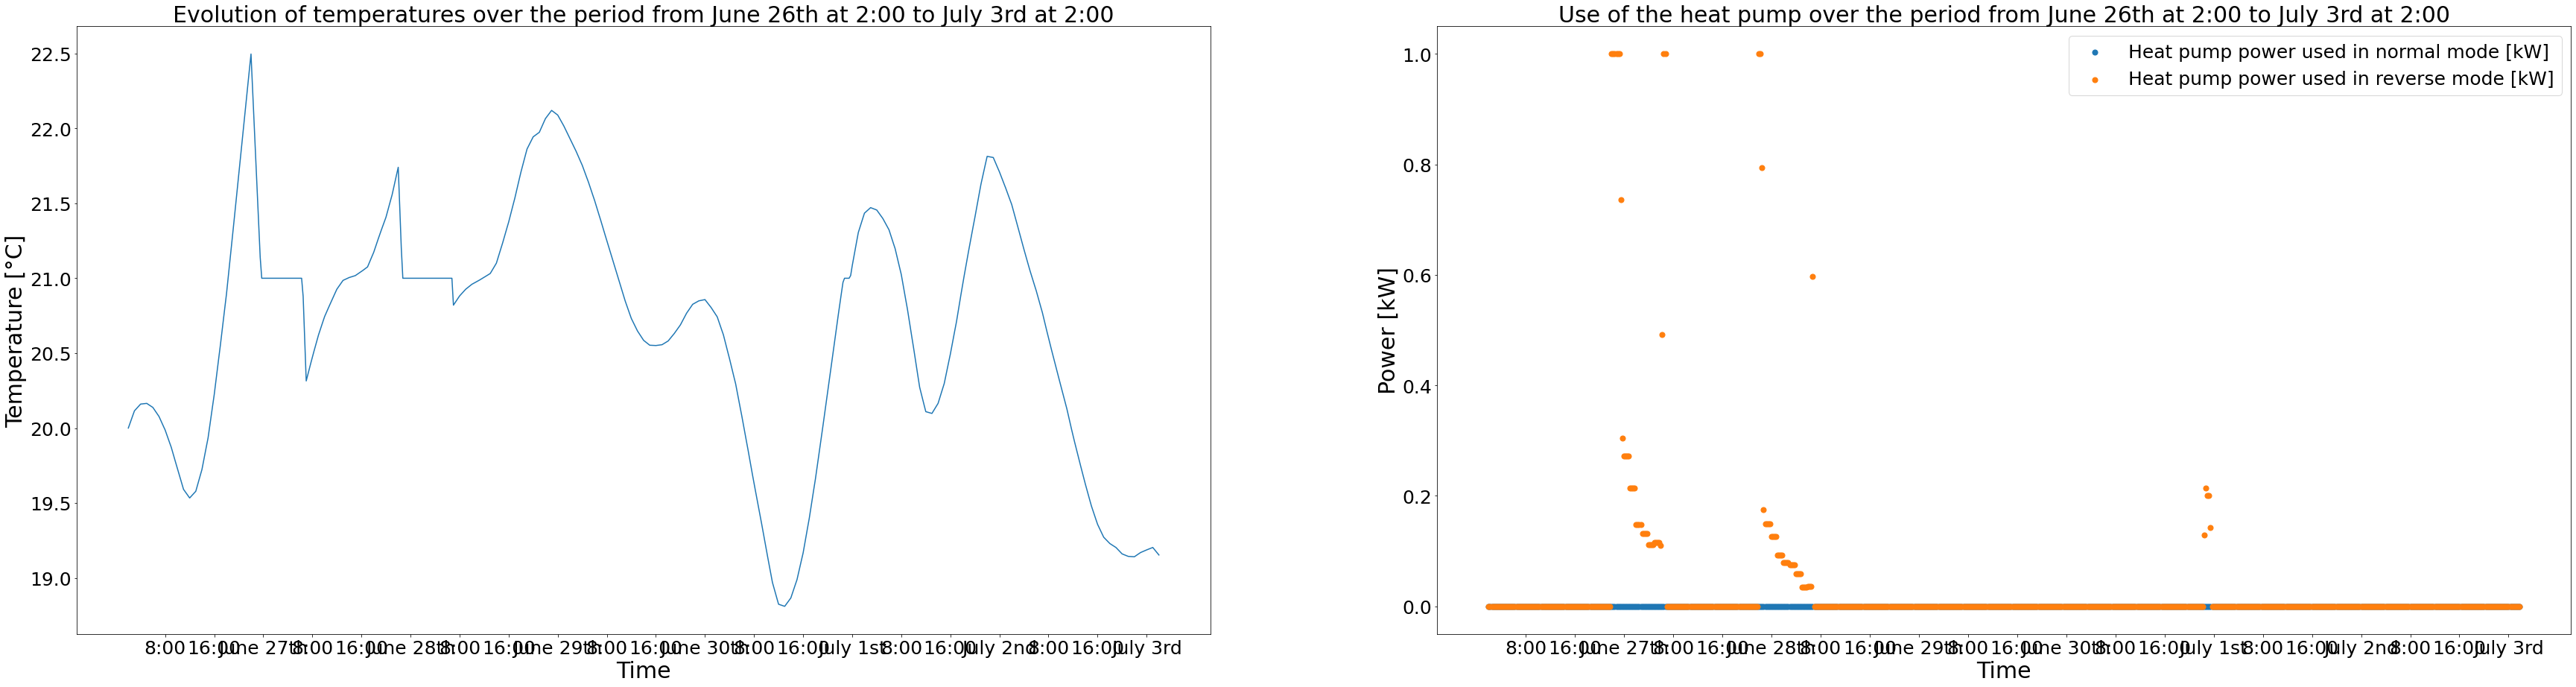

In [24]:
if result2 == "infeasible":
    print(f"The problem is infeasible. The execution lasted {(t1 - t0) * 1000:.3f}ms.")
elif result2 == "unbounded":
    print(f"The problem is unbounded. The execution lasted {(t1 - t0) * 1000:.3f}ms.")
else:
    print(f"Minimal discomfort during the period from June 26th at 2:00 to July 3rd at 2:00: {Discomfort2:.3f}. The execution lasted {((t1 - t0) * 1000):.3f}ms.")
    graph(start, length, T2, x2, y2, ["June 26th at 2:00", "July 3rd at 2:00"], np.arange(17000+24, 17000+672, 32), ["8:00", "16:00", "June 27th", "8:00", "16:00", "June 28th", "8:00", "16:00", "June 29th", "8:00", "16:00", "June 30th", "8:00", "16:00", "July 1st", "8:00", "16:00", "July 2nd", "8:00", "16:00", "July 3rd"])


#### c) Comments

For the first (resp. second) period when the outside temperatures are cold (resp. hot), we observe that the indoor temperature tends to be in the lower (resp. upper) range of acceptable temperatures or even below (resp. above). Moreover, the discomfort for the second period is lower because it is preferable to be above the acceptable range than below. Furthermore, the execution time for this second task is higher than for the first one because there are more constraints. Finally, we observe once again that the heat pump is used at full power more during off-peak hours than peak hours to "consume" as little of the budget as possible.

We now replace the discomfort concept described above with a quadratic penalty: now, discomfort is proportional to the *square* of the exceeding of the maximum permissible temperature or the *square* of the falling below the minimum permissible temperature (the proportionality coefficients remain the same).


<div class="alert alert-block alert-info"><b>Question 2.3</b> :<br> 
    Model this new problem linearly, using an approximation. This approximation could, for example, be based on tangents (choose a not too high number, for instance, 5). Explain your modeling technique. Solve this approximate model, display the solutions, and provide comments (especially on the effect on the solution compared to the initial discomfort model).
</div>


This time, the objective function is $\sum_{j=0}^{n} d_0.\delta_j^2 + d_1.\epsilon_j^2$ with $\delta_j = max\{0,T_{inf}-T_j\}$, $j = 0,...,n$, and $\epsilon_j = max\{0,T_j-T_{sup}\}$, $j = 0,...,n$. The set of constraints remains unchanged from the initial discomfort model.

For a fixed $j$, the discomfort at time $j$ can be represented by the single-variable function $f : \mathbb{R} \to \mathbb{R} : T_j \to d_0.max\{0,T_{inf}-T_j\}^2 + d_1.max\{0,T_j-T_{sup}\}^2$ shown below.

<img src="linear_approximation.png" width="800">

Let's consider the left term of the sum. The function $g : \mathbb{R} \to \mathbb{R} : T \to max\{0, T_{inf}-T\}^2$ being convex and differentiable, we can lower bound it with tangents of the function taken at different points $T_k, k = 1,...,l$. We can then approximate $d_0.\delta_j^2$ (with $\delta_j := max\{0, T_{inf}-T\}$) by $d_0.\tilde{\delta_j}$, $j = 0,...,n$, where $\tilde{\delta_j} = \max\limits_{k = 1,...,l}\{g(T_k) + \frac{dg(T)}{dT}_{\mid T = T_k}.(T-T_k)\}$. By linearizing this constraint, we get the linear constraints $\tilde{\delta_j} \geq g(T_k) + \frac{dg(T)}{dT}_{\mid T = T_k}.(T-T_k)$, $k = 1,...,l$, $j = 0,...,n$.

Similarly, for the right term of the objective function sum, we get that $d_1.\epsilon_j^2$ (with $\epsilon_j := max\{0, T-T_{sup}\}$) can be approximated by $d_1.\tilde{\epsilon_j}$, $j = 0,...,n$, where $\tilde{\epsilon_j} \geq h(T_p) + \frac{dh(T)}{dT}_{\mid T = T_p}.(T-T_p)$, $p = 1,...,q$, and $h : \mathbb{R} \to \mathbb{R} : T \to max\{0, T-T_{sup}\}^2$, which is also convex and differentiable.

Finally, the linear approximation of the problem is:

$$\begin{align}
\text{min} &\sum_{j=0}^{n} d_0.\tilde{\delta_j} + d_1.\tilde{\epsilon_j} \\
&T_0 = T_s\\
&\sum_{i=0}^{n-1} \frac{c_i}{4}.(x_i+y_i) \leq C\\
&\tilde{\delta_j} \geq g(T_k) + \frac{dg(T)}{dT}_{\mid T = T_k}.(T-T_k), k = 1,...,l , j = 0,...,n\\
&\tilde{\epsilon_j} \geq h(T_p) + \frac{dh(T)}{dT}_{\mid T = T_p}.(T-T_p), p = 1,...,q , j = 0,...,n\\
&T_{i+1} = \eta.T_i + (1-\eta).T_{e,i} + \frac{\alpha_i.x_i}{10.\gamma} - \frac{\beta.y_i}{10.\gamma}, i = 0,...,n-1\\
&x_i+y_i \leq \Omega, i = 0,...,n-1\\
&x_i, y_i, \delta_j, \epsilon_j \geq 0, \text{  } i = 0,...,n-1, j = 0,...,n\\
\end{align}$$

Now we need to determine the points $T_k$ and $T_p$. For the points $T_k$, we see that the function $g$ is quadratic before $T_{inf}$ and zero after. Since the derivative of a quadratic function evolves linearly, a good idea would be to take points spaced at regular intervals until reaching $T_{inf}$, as the tangent at all points after $T_{inf}$ is the same as that at $T_{inf}$. Similarly, $T_p$ will be taken at regular intervals starting from $T_{sup}$.


In [25]:
def min_new_discomfort_approx(start, length, C, distance, space):
    """
    This function calculates the times at which we should turn on a heat pump in a 360m³ building in Montreal
    to minimize the discomfort, with a budget constraint.
    Discomfort at time j is defined as (less * max(0,T_inf-T_j)^2 + greater * max(0,T_j-T_sup)^2).
    Since this function cannot be solved with a linear optimization problem, we calculate a linear approximation of the problem.
    We consider a period of `length` days, starting at time `start`.

    Arguments
    ---------
    start     : int indicating the number of the time instant that starts the period of `length` days [-];
    length    : int indicating the number of days over which the optimization algorithm should be applied [days];
    C         : float indicating the maximum cost we are willing to pay for the use of the heat pump over a period of `length` days [$];
    distance  : int indicating up to what distance (not included) from the bounds of the acceptable temperature range we desire tangents [-];
    space     : float indicating the interval length between two abscissas for which we calculate the tangent [°C].

    Returns
    --------
    prob.status : string among {optimal, infeasible, unbounded} indicating if the problem solution is optimal,
                  if the problem is infeasible, or if the solution is unbounded;
    prob.value  : float indicating the minimal discomfort [-]. If the problem is infeasible, prob.value = -inf.
                  If the problem is unbounded, prob.value = -inf;
    T.value     : numpy array of float indicating the temperature in the building during the considered seven-day period,
                  in 15-minute intervals [°C];
    x.value     : numpy array of float indicating the power of the heat pump used in normal mode during different
                  15-minute time intervals [kW];
    y.value     : numpy array of float indicating the power of the heat pump used in reverse mode during different
                  15-minute time intervals [kW];
    """    
    # First, find the costs at different times based on the starting instant's location.
    c = np.repeat(peak, intervals)
    beginning = start % intervals
    moments = np.concatenate((np.arange(beginning, intervals), np.arange(0, beginning)))
    c[moments < start_peak * 60 / m] = off_peak
    c[moments >= end_peak * 60 / m] = off_peak
    c = np.tile(c, length)
    
    # Next, find the outdoor temperatures at these times and the COP of the heat pump used in normal mode.
    Te = outdoor_temperature[start : start+length*intervals]
    COPnor = COPnormal(Te)
    
    # Initialization of the problem variables
    T = cp.Variable(intervals * length + 1)
    x = cp.Variable(intervals * length, nonneg=True)
    y = cp.Variable(intervals * length, nonneg=True)
    ΔinfT = cp.Variable(intervals * length + 1, nonneg=True)
    ΔsupT = cp.Variable(intervals * length + 1, nonneg=True)
    
    # Problem modeling
    objective = cp.Minimize(cp.sum(less * ΔinfT + greater * ΔsupT))
    constraints = [T[0] == Tinit,
                   cp.sum(cp.multiply(c, (x + y)) * m / 60) <= C,
                   T[1:] == eta * T[:672] + (1 - eta) * Te + cp.multiply(COPnor, x) / (10 * capCal) - (COPreverse * y) / (10 * capCal),
                   x + y <= max_power]
    for k in np.arange(space, distance, space):
        constraints.append(ΔinfT >= k**2 - 2 * k * (T - (Tinf - k)))  # Regarding the problem formula, we take Tk = Tinf - k
    for p in np.arange(space, distance, space):
        constraints.append(ΔsupT >= p**2 + 2 * p * (T - (Tsup + p)))  # Regarding the problem formula, we take Tp = Tsup + p

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start=True)

    return (prob.status, prob.value, T.value, x.value, y.value)


#### a) Time interval from May 15th at 10:30 PM to May 22nd at 10:30 PM


In [26]:
start = 13050
length = 7
Cost1 = min_cost(start, length)[1]
t0 = time.time()
(result1, Discomfort1,T1,x1,y1) = min_new_discomfort_approx(start, length, Cost1/2, 3, 1)
t1 = time.time()

Minimal discomfort during the period from May 15th at 22:30 to May 22nd at 22:30: 10980.726. The execution took 160.188ms.


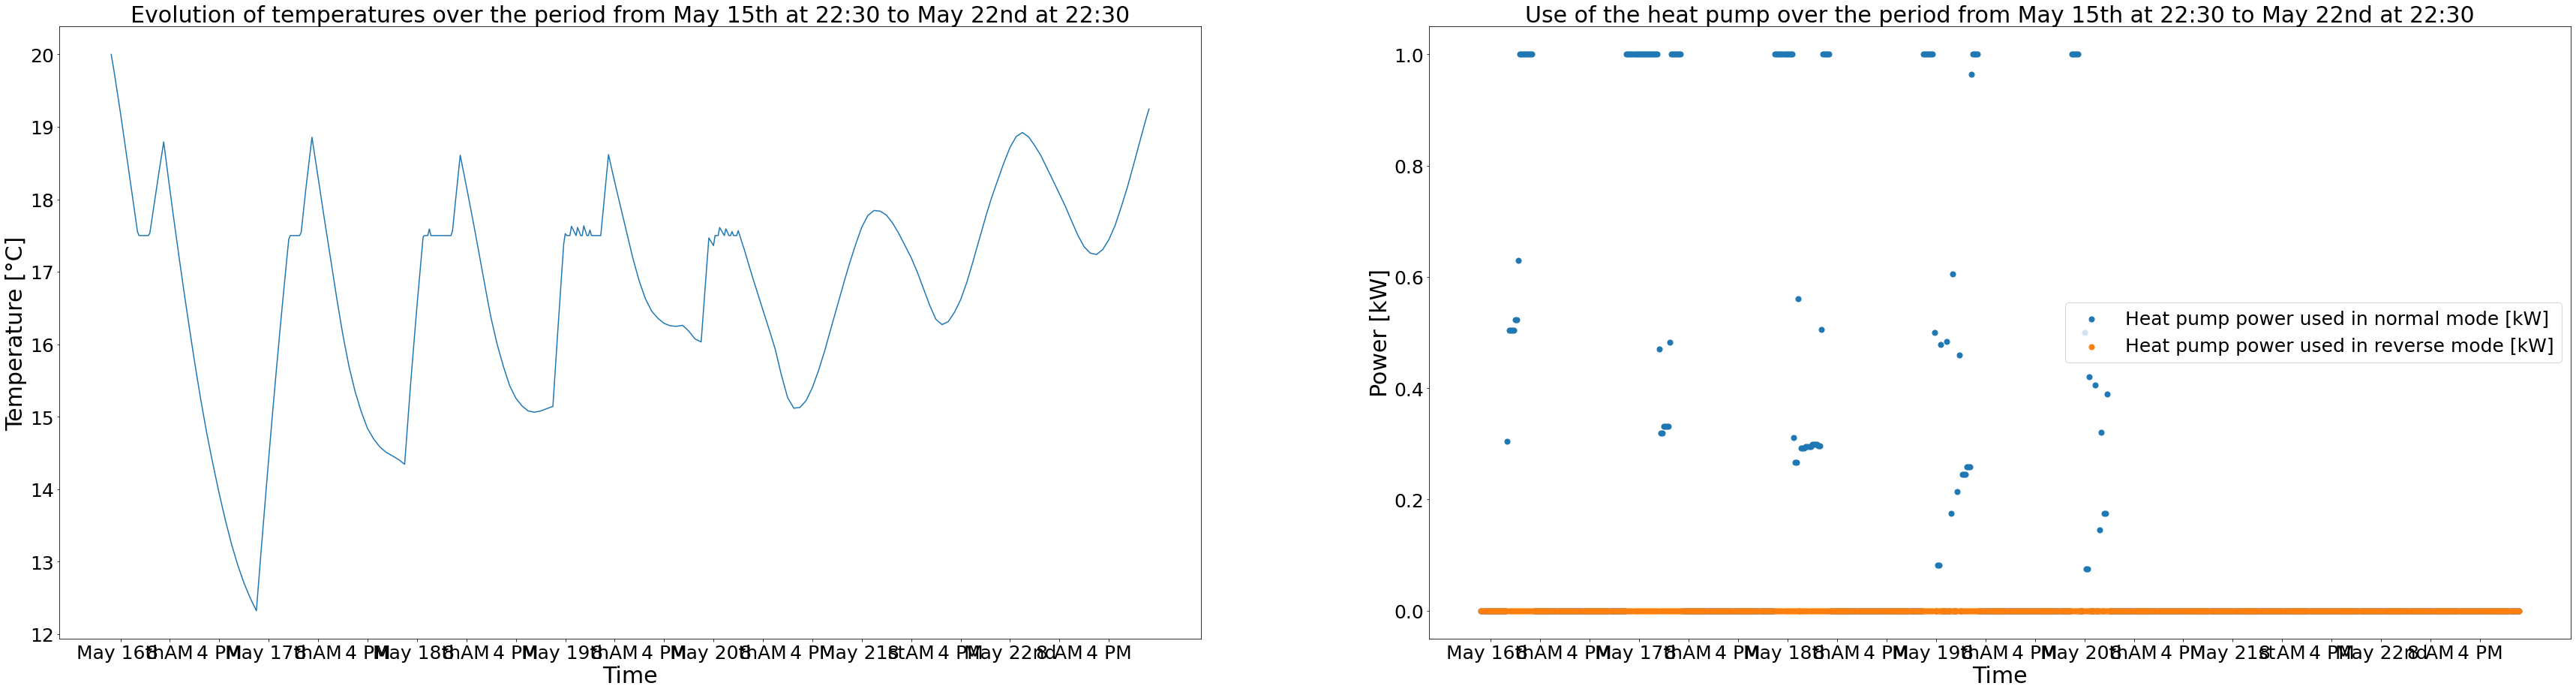

In [27]:
if result1 == "infeasible":
    print(f"The problem is infeasible. The execution took {(t1 - t0) * 1000:.3f}ms.")
elif result1 == "unbounded":
    print(f"The problem is unbounded. The execution took {(t1 - t0) * 1000:.3f}ms.")
else:
    print(f"Minimal discomfort during the period from May 15th at 22:30 to May 22nd at 22:30: {Discomfort1:.3f}. The execution took {((t1 - t0) * 1000):.3f}ms.")
    graph(start, length, T1, x1, y1, ["May 15th at 22:30", "May 22nd at 22:30"], np.arange(13050 + 6, 13050 + 672, 32), ["May 16th", "8 AM", "4 PM", "May 17th", "8 AM", "4 PM", "May 18th", "8 AM", "4 PM", "May 19th", "8 AM", "4 PM", "May 20th", "8 AM", "4 PM", "May 21st", "8 AM", "4 PM", "May 22nd", "8 AM", "4 PM"])


#### b) Time interval from June 26th at 2 AM to July 3rd at 2 AM


In [28]:
start = 17000
length = 7
Cost2 = min_cost(start, length)[1]
t0 = time.time()
(result2, Discomfort2,T2,x2,y2) = min_new_discomfort_approx(start, length, Cost2/2, 1, 0.33)
t1 = time.time()

Minimal discomfort during the period from June 26th at 2 AM to July 3rd at 2 AM: 69.534. The execution lasted 108.449ms.


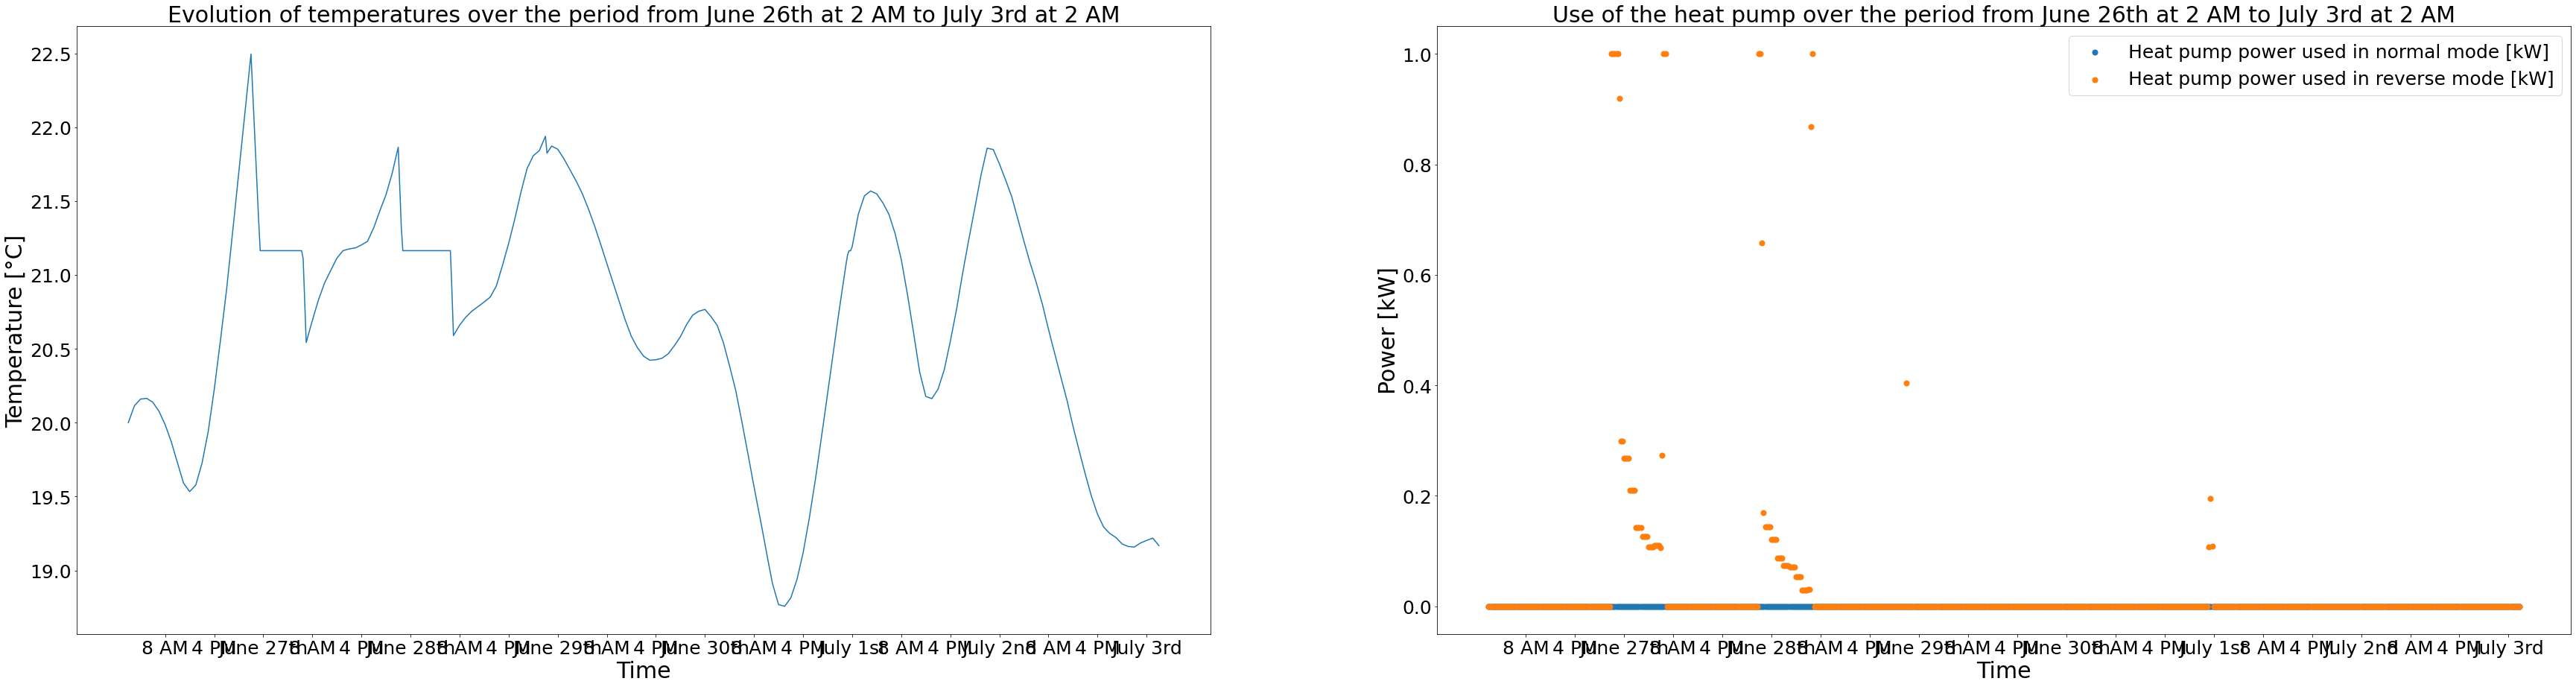

In [29]:
if (result2 == "infeasible"):
    print(f"The problem is infeasible. The execution lasted {(t1-t0)*1000:.3f}ms.")
elif (result2 == "unbounded"):
    print(f"The problem is unbounded. The execution lasted {(t1-t0)*1000:.3f}ms.")
else:
    print(f"Minimal discomfort during the period from June 26th at 2 AM to July 3rd at 2 AM: {Discomfort2:.3f}. The execution lasted {((t1-t0)*1000):.3f}ms.")
    graph(start, length, T2, x2, y2, ["June 26th at 2 AM", "July 3rd at 2 AM"], np.arange(17000+24, 17000+672, 32), ["8 AM", "4 PM", "June 27th", "8 AM", "4 PM", "June 28th", "8 AM", "4 PM", "June 29th", "8 AM", "4 PM", "June 30th", "8 AM", "4 PM", "July 1st", "8 AM", "4 PM", "July 2nd", "8 AM", "4 PM", "July 3rd"])


#### c) Comments

For both the first and second periods, we observe that the graphs have a similar appearance to those obtained with the initial model. However, we notice that the temperature graphs of the linear approximation of this new model tend to be slightly less smooth with a bit more low-frequency oscillations in some places. Regarding the execution time, solving this new model generally takes more time than the initial model. The execution time increases with the number of tangents.

We still need to analyze the minimal discomfort. It exhibits a peculiar behavior. Indeed, for the first period, it is much higher than that of the initial model, while for the second period, the minimal discomfort has decreased compared to the initial model. This phenomenon is entirely logical. For the second period, the temperature is mostly within a distance of 1 from the desired temperature bounds. When we square this distance, the obtained number is smaller than the distance (when the distance is less than 1). Therefore, the discomfort is lower: $ax^2 \leq ax \text{ if } x \leq 1$. For the first period, the temperature deviates much more from the desired temperature range, and squaring significantly increases the discomfort.


<div class="alert alert-block alert-info"><b>Question 2.4</b> :<br> 
    To conclude this section, solve this new model once again, but this time exactly, using a quadratic solver. Compare it with the approximate solution obtained earlier (solutions, computation time).
</div>


In [30]:
def min_new_discomfort(start, length, C):
    """
    This function calculates the times at which we should turn on a heat pump in a 360m³ building in Montreal
    to minimize the discomfort, with a budget constraint.
    Discomfort at time j is defined as (less * max(0, T_inf - T_j)^2 + greater * max(0, T_j - T_sup)^2).
    The problem is solved exactly.
    We consider a period of `length` days, starting at time `start`.

    Prerequisite
    ------------
    Have the clarabel optimization module installed (pip install clarabel)

    Arguments
    ---------
    start  : int indicating the number of the time instant that starts the period of `length` days [-];
    length : int indicating the number of days over which the optimization algorithm should be applied [days];
    C      : float indicating the maximum cost we are willing to pay for the use of the heat pump over a period of `length` days [$];

    Returns
    --------
    prob.status : string among {optimal, infeasible, unbounded} indicating if the problem solution is optimal,
                  if the problem is infeasible, or if the solution is unbounded;
    prob.value  : float indicating the minimal discomfort [-]. If the problem is infeasible, prob.value = -inf.
                  If the problem is unbounded, prob.value = -inf;
    T.value     : numpy array of float indicating the temperature in the building during the considered seven-day period,
                  in 15-minute intervals [°C];
    x.value     : numpy array of float indicating the power of the heat pump used in normal mode during different
                  15-minute time intervals [kW];
    y.value     : numpy array of float indicating the power of the heat pump used in reverse mode during different
                  15-minute time intervals [kW];
    """    
    # First, find the costs at different times based on the starting instant's location.
    c = np.repeat(peak, intervals)
    beginning = start % intervals
    moments = np.concatenate((np.arange(beginning, intervals), np.arange(0, beginning)))
    c[moments < start_peak * 60 / m] = off_peak
    c[moments >= end_peak * 60 / m] = off_peak
    c = np.tile(c, length)
    
    # Next, find the outdoor temperatures at these times and the COP of the heat pump used in normal mode.
    Te = outdoor_temperature[start : start + length * intervals]
    COPnor = COPnormal(Te)
    
    # Initialization of the problem variables
    T = cp.Variable(intervals * length + 1)
    x = cp.Variable(intervals * length, nonneg=True)
    y = cp.Variable(intervals * length, nonneg=True)
    ΔinfT = cp.Variable(intervals * length + 1, nonneg=True)
    ΔsupT = cp.Variable(intervals * length + 1, nonneg=True)
    
    # Problem modeling
    objective = cp.Minimize(cp.sum(less * cp.square(ΔinfT) + greater * cp.square(ΔsupT)))
    constraints = [T[0] == Tinit,
                   cp.sum(cp.multiply(c, (x + y)) * m / 60) <= C,
                   ΔinfT >= Tinf - T,
                   ΔsupT >= T - Tsup,
                   T[1:] == eta * T[:672] + (1 - eta) * Te + cp.multiply(COPnor, x) / (10 * capCal) - (COPreverse * y) / (10 * capCal),
                   x + y <= max_power]

    # Solve the problem
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.CLARABEL, warm_start=True)

    return (prob.status, prob.value, T.value, x.value, y.value)


#### a) Time interval from May 15th at 10:30 PM to May 22nd at 10:30 PM


In [31]:
start = 13050
length = 7
Cost1 = min_cost(start, length)[1]
t0 = time.time()
(result1, Discomfort1,T1,x1,y1) = min_new_discomfort(start, length, Cost1/2)
t1 = time.time()

Minimal discomfort during the period from May 15 at 22:30 to May 22 at 22:30: 13905.627. The execution took 46.092ms.


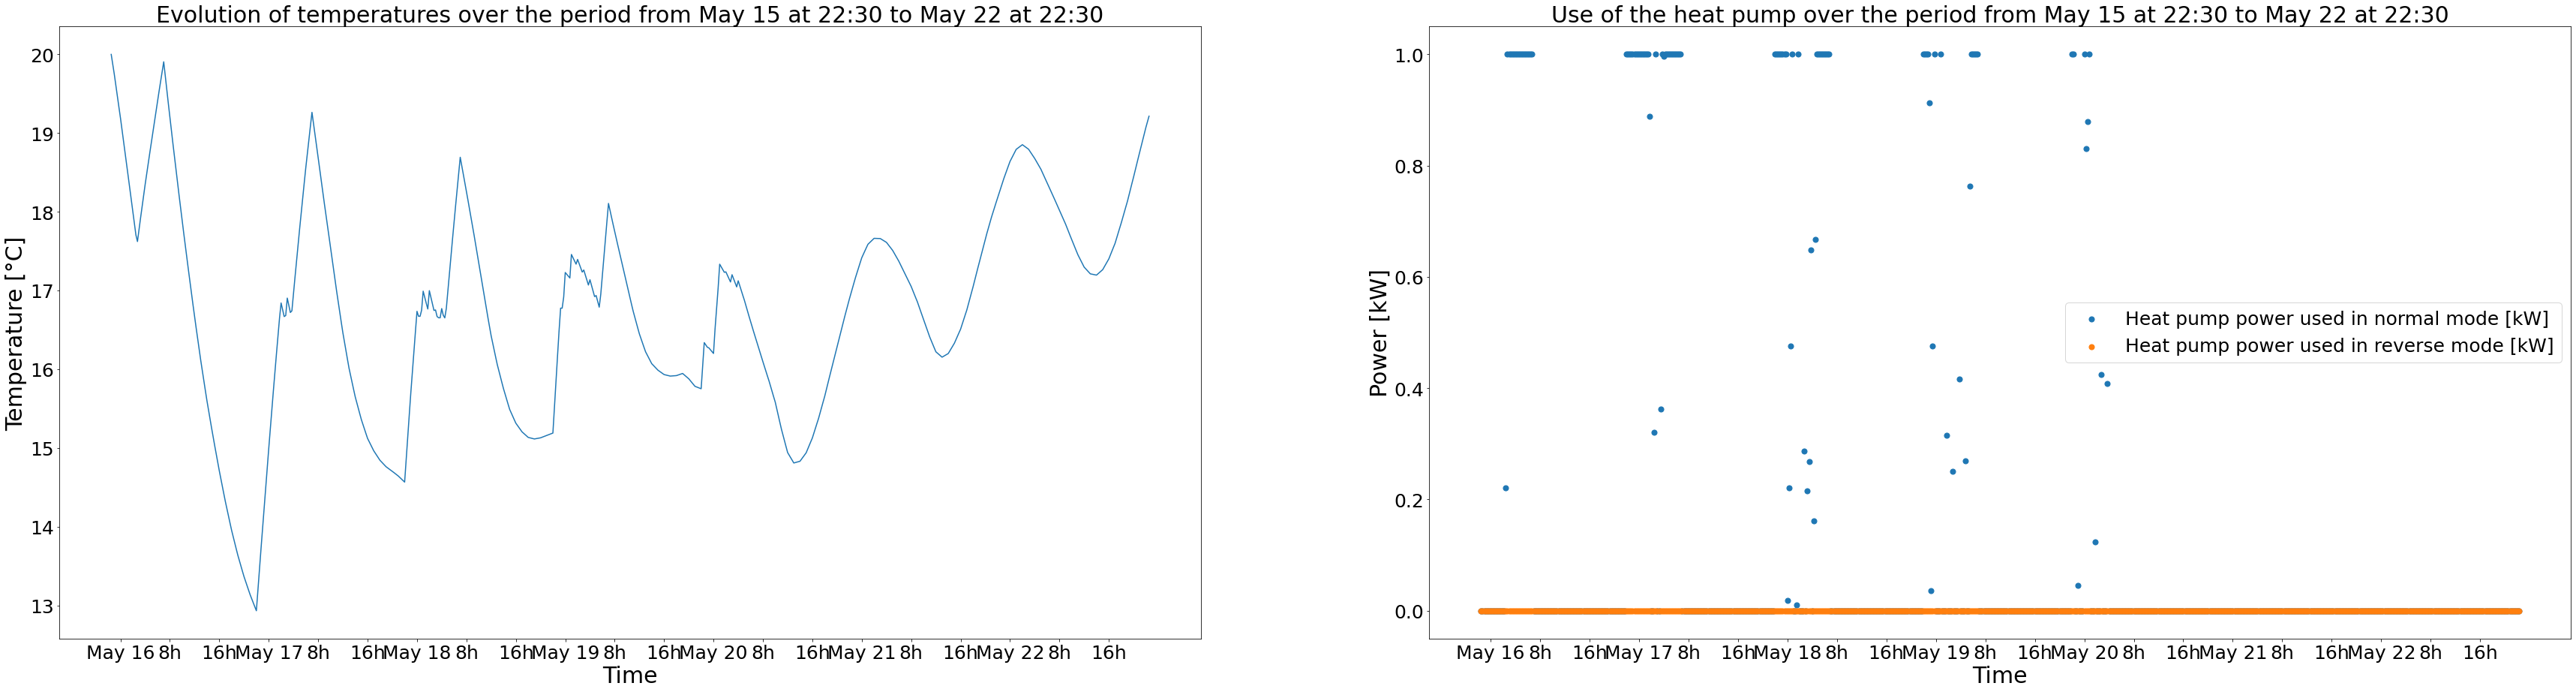

In [32]:
if result1 == "infeasible":
    print(f"The problem is infeasible. The execution took {(t1 - t0) * 1000:.3f}ms.")
elif result1 == "unbounded":
    print(f"The problem is unbounded. The execution took {(t1 - t0) * 1000:.3f}ms.")
else:
    print(f"Minimal discomfort during the period from May 15 at 22:30 to May 22 at 22:30: {Discomfort1:.3f}. The execution took {((t1 - t0) * 1000):.3f}ms.")
    graph(start, length, T1, x1, y1, ["May 15 at 22:30", "May 22 at 22:30"], np.arange(13050 + 6, 13050 + 672, 32), ["May 16", "8h", "16h", "May 17", "8h", "16h", "May 18", "8h", "16h", "May 19", "8h", "16h", "May 20", "8h", "16h", "May 21", "8h", "16h", "May 22", "8h", "16h"])


#### b) Time interval from June 26 at 2:00 to July 3 at 2:00


In [33]:
start = 17000
length = 7
Cost2 = min_cost(start, length)[1]
t0 = time.time()
(result2, Discomfort2,T2,x2,y2) = min_new_discomfort(start, length, Cost2/2)
t1 = time.time()

Inconfort minimal lors de la période allant du 26 juin à 2h au 3 juillet à 2h : 74.705. L'exécution a duré 42.793ms.


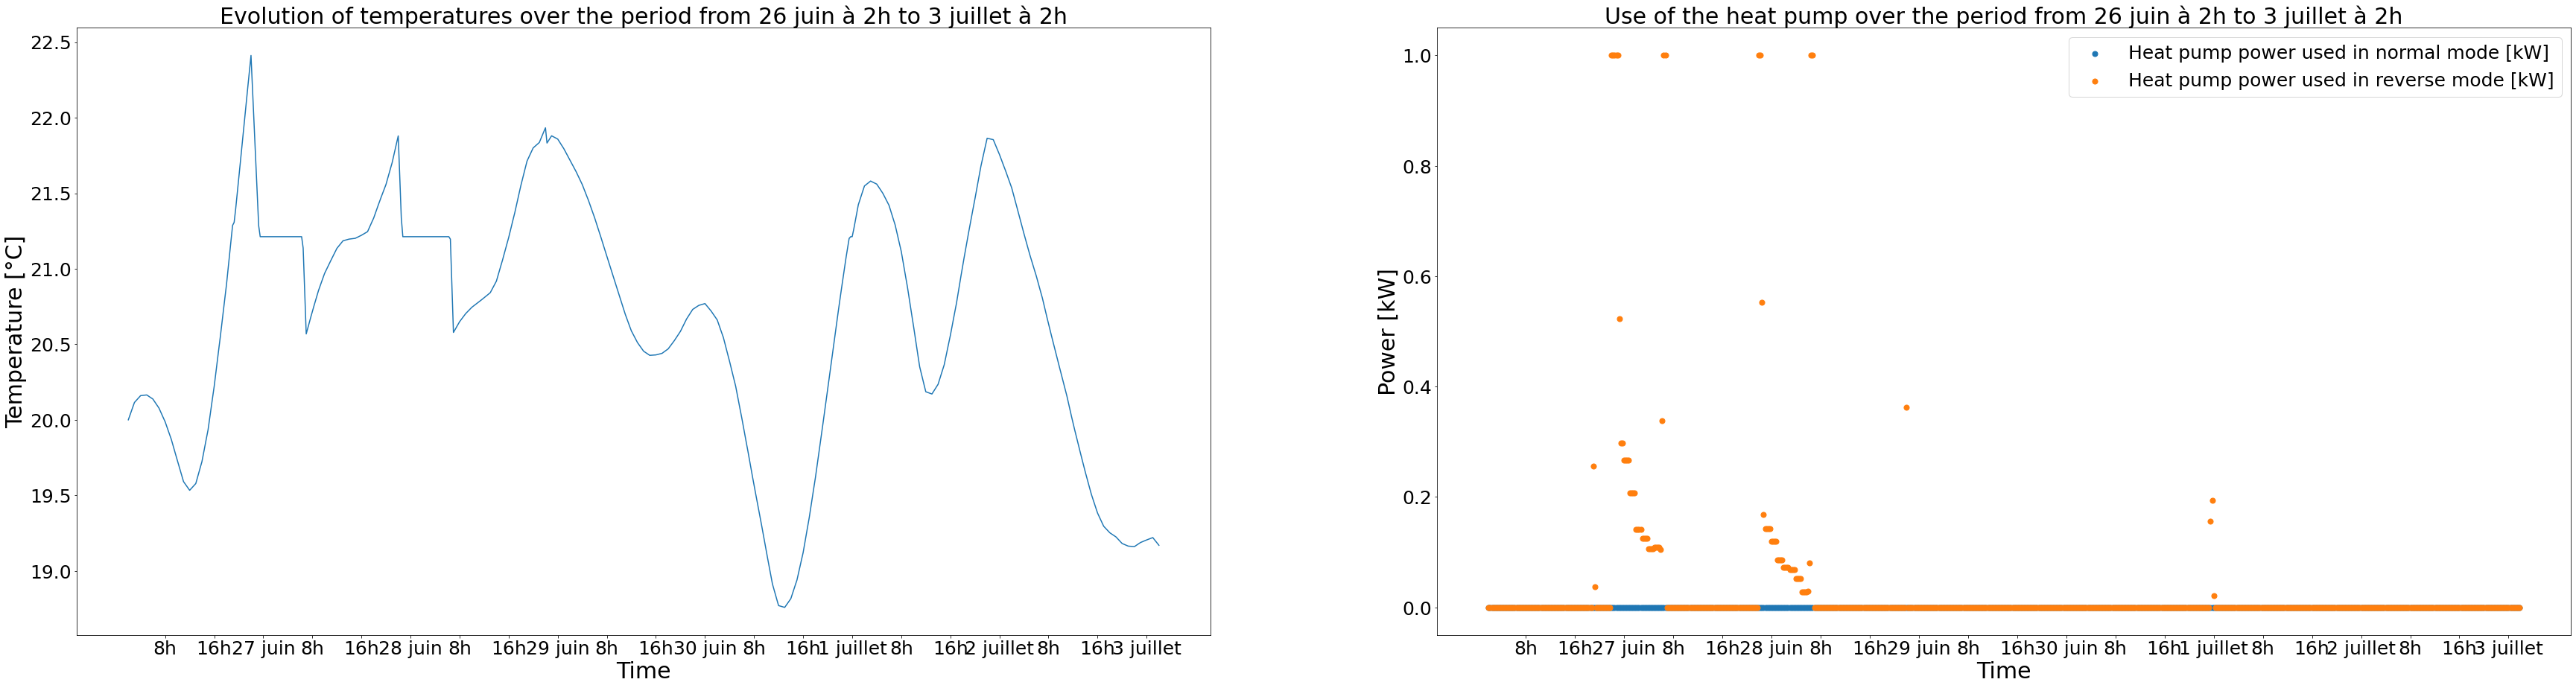

In [34]:
if result2 == "infeasible":
    print(f"Le problème est infaisable. L'exécution a duré {(t1 - t0) * 1000:.3f}ms.")
elif result2 == "unbounded":
    print(f"Le problème est non borné. L'exécution a duré {(t1 - t0) * 1000:.3f}ms.")
else:
    print(f"Inconfort minimal lors de la période allant du 26 juin à 2h au 3 juillet à 2h : {Discomfort2:.3f}. L'exécution a duré {((t1 - t0) * 1000):.3f}ms.")
    graph(start, length, T2, x2, y2, ["26 juin à 2h", "3 juillet à 2h"], np.arange(17000 + 24, 17000 + 672, 32), ["8h", "16h", "27 juin", "8h", "16h", "28 juin", "8h", "16h", "29 juin", "8h", "16h", "30 juin", "8h", "16h", "1 juillet", "8h", "16h", "2 juillet", "8h", "16h", "3 juillet"])


#### c) Comments

We observe that the exact solution is higher than the previously approximated one. Indeed, the exact solution can be seen as the limit when the number of tangents approaches infinity in the approximation. As the tangents are always below the graph, the value of the objective function will be lower in the case of the approximation.
Therefore, we can get closer to this optimal solution by increasing, on the one hand, the distance between the admissible temperature zone and the abscissa at which the last tangent is calculated, and, on the other hand, by decreasing the spacing between the abscissas at which the tangents are calculated. However, the more we want to improve the accuracy of the linear approximation, the longer the execution will take, while the exact solution will be obtained much faster.


**Task 3**: Now, we would like to better understand the compromise between the allocated budget and the resulting total discomfort. Propose a **graph that effectively represents this relationship between budget and discomfort**. Vary the budget from zero to the minimum cost identified in task 1 (this budget will be indicated as a percentage, from 0 to 100%). This will require solving multiple problems, and it would be wise to use the warm start functionality of the solver to speed up calculations.

<div class="alert alert-block alert-warning"><b>To mention</b>:<br> 
- Requested graph + total calculation time and average time per problem + brief comment (maximum 4 lines)<br>
- Again, for the two periods mentioned in tasks 1 and 2
</div>


<div class="alert alert-block alert-info"><b>Question 3.1</b> :<br> 
    Provide the requested graph and comments as mentioned above.
</div>


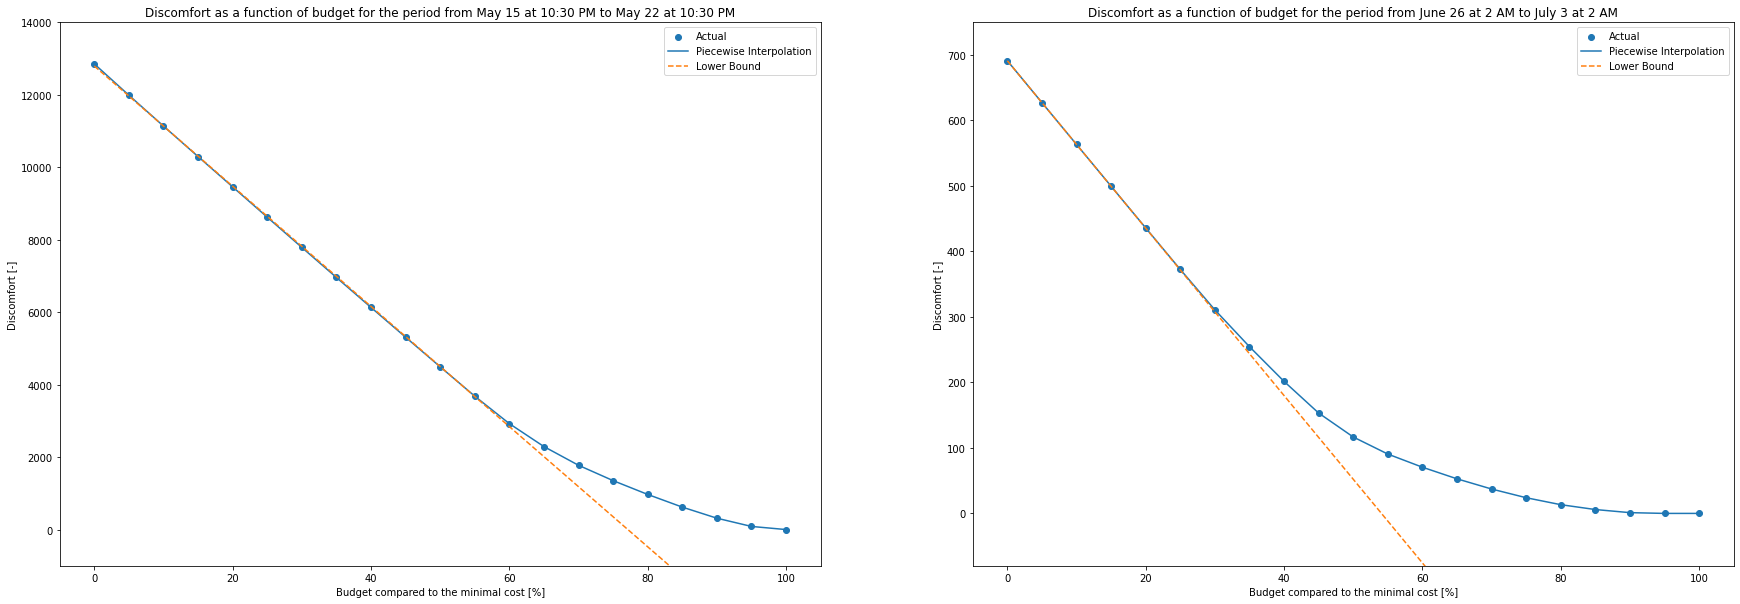

Execution time for the period from May 15 at 10:30 PM to May 22 at 10:30 PM: 1.798s
Average execution time for the period from May 15 at 10:30 PM to May 22 at 10:30 PM: 0.086s
Execution time for the period from June 26 at 2 AM to July 3 at 2 AM: 1.339s
Average execution time for the period from June 26 at 2 AM to July 3 at 2 AM: 0.064s


In [35]:
t10 = time.time()

budget = cp.Parameter(nonneg=True)

start1 = 13050
length1 = 7
Cost1 = min_cost(start1, length1)[1]
budget1 = np.linspace(0, Cost1, 21)
discomfort1 = np.zeros(21)

for i in range(21):
    budget.value = budget1[i]
    discomfort1[i] = min_discomfort(start1, length1, budget)[1]

t11 = time.time()

t20 = time.time()

start2 = 17000
length2 = 7
Cost2 = min_cost(start2, length2)[1]
budget2 = np.linspace(0, Cost2, 21)
discomfort2 = np.zeros(21)

for i in range(21):
    budget.value = budget2[i]
    discomfort2[i] = min_discomfort(start2, length2, budget)[1]

t21 = time.time()

fig = plt.figure(figsize=(30, 10))
fig.tight_layout(pad=2.0)
plt.subplot(1, 2, 1)
plt.scatter(np.arange(0, 101, 5), discomfort1, label="Actual")
plt.plot(np.arange(0, 101, 5), discomfort1, label="Piecewise Interpolation")
# Linear approximation:
coeff = np.polyfit(budget1[:13], discomfort1[:13], 1)
val = np.polyval(coeff, Cost1 * np.arange(0, 101, 5) / 100)
plt.plot(np.arange(0, 101, 5), val, "--", label="Lower Bound")
plt.title("Discomfort as a function of budget for the period from May 15 at 10:30 PM to May 22 at 10:30 PM")
plt.xlabel("Budget compared to the minimal cost [%]")
plt.ylabel("Discomfort [-]")
plt.ylim((-1000, 14000))
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.scatter(np.arange(0, 101, 5), discomfort2, label="Actual")
plt.plot(np.arange(0, 101, 5), discomfort2, label="Piecewise Interpolation")
# Lower Bound:
coeff2 = np.polyfit(budget2[:3], discomfort2[:3], 1)
val2 = np.polyval(coeff2, Cost2 * np.arange(0, 101, 5) / 100)
plt.plot(np.arange(0, 101, 5), val2, "--", label="Lower Bound")
plt.title("Discomfort as a function of budget for the period from June 26 at 2 AM to July 3 at 2 AM")
plt.xlabel("Budget compared to the minimal cost [%]")
plt.ylabel("Discomfort [-]")
plt.ylim((-80, 750))
plt.legend(loc='upper right')

plt.show()

print(f"Execution time for the period from May 15 at 10:30 PM to May 22 at 10:30 PM: {t11 - t10:.3f}s")
print(f"Average execution time for the period from May 15 at 10:30 PM to May 22 at 10:30 PM: {(t11 - t10) / 21:.3f}s")
print(f"Execution time for the period from June 26 at 2 AM to July 3 at 2 AM: {t21 - t20:.3f}s")
print(f"Average execution time for the period from June 26 at 2 AM to July 3 at 2 AM: {(t21 - t20) / 21:.3f}s")


Discomfort decreases as the budget increases until reaching the optimal cost from the task 1 problem. For this optimal cost, it is possible to stay perfectly within the admissible temperature zone, resulting in zero discomfort. It is evident that this zero discomfort solution remains valid for a budget higher than the optimal cost, and discomfort will be zero for any budget greater than the optimal cost from task 1.


<div class="alert alert-block alert-info"><b>Question 3.2</b> :<br> 
    Explain the linear slope observed in the obtained graph. Recalculate the slope value using the information provided by the solver for the resolution with the maximum budget (task 2) and compare it to the slope observed in the graph. Finally, explain why the graph ceases to be a straight line at a certain point.
</div>

The theory predicts that a linear modification of the right-hand side of a constraint leads to a linear decrease (as it is a minimization) in the optimal cost until the point where the basis is no longer admissible. In this case, the decrease is not entirely linear because the basis changes. However, up to approximately $60\%$ (resp. $40\%$) of the minimal budget, the change in the basis is not very pronounced. Therefore, we can use the theory to provide a linear slope that approximates the variation of discomfort with respect to the budget.

The discomfort will decrease approximately by $\Delta B \cdot \upsilon_C^*$, with $\Delta B$ being the budget variation and $\upsilon_C^*$ being the value of the dual variable related to the budget constraint before the budget modification, until the change in the basis becomes significant. The slope of discomfort concerning the budget is thus approximately equal to $\upsilon_C^*$, which averages to $-2035$ for the first period and $-677$ for the second period (measurements were taken up to $55\%$ and $30\%$ of the optimal cost, respectively).

In [36]:
print(f"Value of the slope of the line in the graph of discomfort as a function of the budget for period 1: {((discomfort1[11] - discomfort1[0])/(budget1[11] - budget1[0])):.3f}")
print(f"Value of the slope of the line in the graph of discomfort as a function of the budget for period 2: {((discomfort2[6] - discomfort2[0])/(budget2[6] - budget2[0])):.3f}")


Value of the slope of the line in the graph of discomfort as a function of the budget for period 1: -2037.343
Value of the slope of the line in the graph of discomfort as a function of the budget for period 2: -682.039


The slopes of the lines taken from the graphs correspond to the slopes calculated with the theory (with a small margin of error due to the fact that the decrease in the budget is not perfectly linear).

The graph ceases to follow a straight line at a certain point because the optimal basis changes significantly. The optimal solution then decreases more slowly until reaching zero discomfort. However, the line still serves as a lower bound on the optimal cost.

---

## Instructions and Tips
- The project is carried out in groups of (maximum) four students (see groups formed on Moodle).

- The assistant in charge of the project is Guillaume Van Dessel. All questions about the project should be asked via Moodle in the forum dedicated to the project (and not through individual messages/emails). Office hours will be scheduled and announced via Moodle.

- It is strongly recommended to use a modeling language to formulate and solve your linear optimization problems. We recommend using the CVXPY module combined with the HIGHS optimization solver (we have verified that this combination is sufficiently efficient for the project).

- Groups can exchange their thoughts, share ideas, and compare their results. However, they cannot copy reasoning, solutions, or computer code. The use of any external information or assistance must be mentioned in the report, citing the source.

- Your final report will consist of this completed notebook, where you will have inserted your codes, results, graphs, and comments.

- This report is to be submitted no later than **Wednesday, May 24, 2023**, at midnight (evening), via Moodle, in the form of a compressed archive containing your notebook and all necessary files to make it work (Python code, etc.). The notebook should contain the cells in already evaluated form (results, tables, graphs, etc.), but should also be able to be re-evaluated in full.

- Organize your group work efficiently and distribute the tasks among yourselves. The tasks to be carried out during this second part are *largely independent* of each other.

### Changelog
- 2023-03-24 v1
- 2023-04-23 v1.1 with a recap of clarifications provided on Moodle (in blue)
- 2023-04-28 description of tasks for the second part
- 2023-05-12 v2 with the expected format (notebook) for the final report